In [26]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from jqfactor import get_all_factors, get_factor_values
from packages.fortune import fortune as ft
import pickle
from datetime import datetime
import os
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from statsmodels.api import OLS, add_constant
import warnings

warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimSun']  # 正常显示中文
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 动态情景多因子 Alpha 模型

动态情景多因子模型（Dynamic Contextual Alpha Model, DCAM）最早在2005年提出，已经有近20年的历史了。

原文：

- [Models, and Active Management 2005](doc/Models, and Active Management 2005.pdf)
- [动态情景多因子Alpha模型](doc/8. 动态情景多因子Alpha模型.pdf)
- [动态情景Alpha模型再思考](doc/19. 动态情景Alpha模型再思考.pdf)

什么是Alpha模型？

Alpha模型的目的是将“好股票”和“坏股票”区分开，区分开的方法往往是通过“打分”获得一个排序。因此Alpha模型的本质是**给每只股票打分**，好的Alpha模型就像一套合理的评分体系，能够正确地区分赚钱的股票和亏钱的股票。这里涉及两个步骤：

- 因子的挑选（e.g. 期中期末、作业分、小组pre）
- 不同因子之间权重的分配方式（e.g. 总成绩占比）

传统的Alpha模型对所有股票一视同仁，这种做法忽视了个股间基本面的差异。

DCAM中涉及两种类型的因子：情景分层因子、Alpha因子。

- 情景分层因子的作用是捕捉个股间基本面的差异，从而分成不同样本空间。这很重要，因为根据我们的经验，同一个因子在不同指数成分股中的表现有明显差异（比如沪深300vs上证中小盘指数），这就是样本空间的不同导致的
- Alpha因子的作用是预测股票收益率，这和经典的多因子模型一样


## 情景因子挑选

### 初步筛选

1. 因子对市场风格的切换具有较强的捕捉能力，具体表现为 Rank IC 正负显著比例之和在 70%以上。
2. 因子本身应当相对稳定，具体表现为较高的线性自相关系数(85%以上)。不同分层因子之间的因子值的横截面秩相关系数应当较低，能够在不同维度刻画股票的特征。
3. 因子定义简单，逻辑明确，因子在样本空间的覆盖率高(95%以上)， 同时应当覆盖所有行业。

In [2]:
def store_output(func, params=None, filename='output.pkl', root='.'):  #@save
    """
    储存某个函数的输出结果
    params:
        func (callable): The function to be called.
        params (tuple): The parameters to pass to the function.
        filename (str): The name of the file to store the output.
        root (str): The directory where the output file will be stored.
    return:
        output
    """
    # Call the function and get the output
    if isinstance(params, dict):
        # use keyword arguments
        try:
            output = func(**params)
        except:
            output = func(params)
    elif isinstance(params, tuple):
        # use positional arguments
        output = func(*params)
    elif params is None:
        # call the function without arguments
        output = func()
    else:
        output = func(params)

    filepath = os.path.join(root, filename)
    if not os.path.exists(root):
        os.makedirs(root)
    with open(filepath, 'wb') as f:
        pickle.dump(output, f)

    ft.log_print(f"Output stored in {filepath}")

    return output

In [3]:
######################################### 执行脚本 ###################################################
start_date = "20160131"
end_date = "20240331"
date_list = ft.get_calendar(start_date=start_date, end_date=end_date, freq="M")
factor_list = ["size", "book_to_price_ratio", "net_asset_growth_rate", "roe_ttm", "VOL60"]
file_path = "result/DCAM/"
file_name = "fac_ret_dict.pkl"

if not os.path.exists(file_path+file_name):
    fac_ret_dict = ft.store_output(ft.get_fac_ret_dict, (date_list, factor_list, "000985.XSHG"), file_name, file_path)
else:
    with open(os.path.join(file_path, file_name), "rb") as f:
        fac_ret_dict = pickle.load(f)
        
# 初步筛选
IC_df, IC_stats_df = ft.factor_ic_test(fac_ret_dict, factor_list)
IC_stats_df

,IC_mean,IC_std,IR,sig_prop,t-value,coverage,autocorr
size,-0.024318,0.181610,-0.133905,0.937500,-1.318806,0.694085,0.137778
book_to_price_ratio,0.053579,0.159473,0.335977,0.885417,3.308990,0.694085,0.176803
net_asset_growth_rate,-0.001459,0.097680,-0.014936,0.885417,-0.147101,0.694085,0.030545
roe_ttm,0.016203,0.117839,0.137504,0.895833,1.354253,0.694085,0.035443
VOL60,-0.079840,0.171938,-0.464355,0.927083,-4.573367,0.694085,0.175625


### 情景因子筛选结果


|风格维度|因子名称|因子定义|
|----|-----|-----|
| 规模 | size | 公司的总市值的自然对数 |
| 价值 | book_to_price_ratio | 最新一季财报的账面价值与当前市值的比值 |
| 成长 | net_asset_growth_rate | 净资产增长率 |
| 盈利 | roe_ttm | 权益回报率TTM |
| 流动性 | VOL60 | 60日平均换手率 |


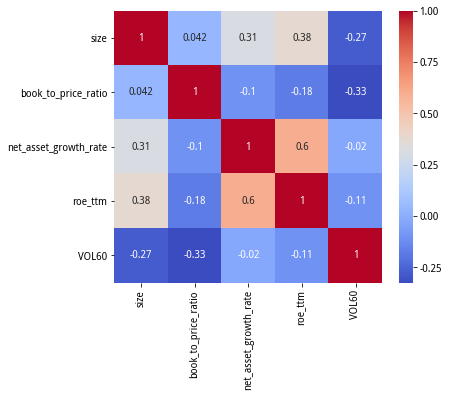

In [4]:
factor_list = ["size", "book_to_price_ratio", "net_asset_growth_rate", "roe_ttm", "VOL60"]
avg_cor = ft.get_factor_corr(fac_ret_dict, factor_list)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cor, annot=True, cmap="coolwarm", cbar=True)
plt.show()

### 验证细节设定

因子检验的细节设定如下：

1. 时间区间为 2019.01.02 - 2024.01.02
2. 检验样本空间为中证全指（000985.XSHG）成分股。每个月末按照分层因子首先将全样本空间等分成两块，每一块的股票数量相同，如大市值样本空间和小市值样本空间。然后计算其他因子在不同样本空间的**风险调整后** Rank IC 和 IC_IR。
3. 所有的因子检验前经过中位数去极值，标准化，行业和市值的中性化处理。

不同于原始的 Rank IC，风险调整 IC 定义如下：

$$
IC_{\text{adj}}=corr(\varepsilon_{fac},\varepsilon_{ret})
$$

其中 $\varepsilon_{fac},\varepsilon_{ret}$ 分别为对上期因子值和这期股票收益率做截面回归得到的残差项。以 $\varepsilon_{fac}$ 为例

$$
f=b_1X+b_2\log(M)+\varepsilon_{fac}
$$

经过OLS回归得到回归系数 $b_1,b_2$，则

$$
\varepsilon_{fac}=f-\hat{b}_1X-\hat{b}_2\log(M)
$$

其中 $X$ 是行业虚拟变量矩阵，$\log(M)$ 是总市值的对数，$f$ 是上个月末的原始因子值，$r$ 是当月个股的收益率。

### 分层验证

用某个情景因子进行分层（high和low），计算Alpha因子每个层次下的IC均值、IC标准差、ICIR，用 Two Sample t-test 和 F test 分别检验 IC 均值和标准差是否有显著差异，若显著则说明这个情景因子能有效地把“好坏”股票区分开。

Alpha因子取自聚宽因子库，因子库中将所有因子分为以下几大类

- basics：基础因子
- emotion：情绪因子
- growth：成长因子
- momentum：动量因子
- pershare：每股因子
- quality：质量因子
- risk：风险因子
- style：风格因子
- technical：技术因子

本文档遵循原文的 Alpha 因子选择

| 因子名称 | 因子含义|
|--|-- |
| earnings_to_price_ratio | 过去12个月的归母净利润除以当前股票市值 |
| sales_to_price_ratio | 营收市值比 |
| roa_ttm | 资产回报率 |
| PEG | 市盈率相对盈利增长比率 |
| net_profit_growth_rate | 净利润增长率 |
| BIAS60 | 60日乖离率 |
| VOL20 | 20日平均换手率 |

对每个情景因子都做如上验证，争取得到统计学上的支持，然后从经济含义上寻求解释。这一步的目的是增强说服力，在复现时为保证完整性可以选一个情景因子进行验证，文字解释这一步不是很重要。

In [193]:
def stratified_validation(_date_list, _fac_ret_dict, _ctxt_fac, _alpha_fac_ret_dict):
    _alpha_fac = _alpha_fac_ret_dict[_date_list[0]].columns.tolist()
    end_idx = _alpha_fac.index(0)
    _alpha_fac = _alpha_fac[:end_idx]
    low_df = pd.DataFrame(0, index=_date_list, columns=_alpha_fac)
    high_df = pd.DataFrame(0, index=_date_list, columns=_alpha_fac)
    
    def _spearman_corr_multiple(group, fixed_column, cols):
        correlations = {}
        for col in cols:
            correlations[col] = group[col].corr(group[fixed_column], method='spearman')
        return pd.Series(correlations)
    
    for day in _date_list[:-1]:
        fac_df = _fac_ret_dict[day][_ctxt_fac]
        alpha_df = _alpha_fac_ret_dict[day]
        alpha_df = pd.concat([fac_df, alpha_df], axis=1, sort=True)
        ctxt_median = fac_df.median()
        bins = [fac_df.min(), ctxt_median, fac_df.max()]
        labels = ["Low", "High"]
        alpha_df["label"] = pd.cut(alpha_df[_ctxt_fac], bins=bins, labels=labels)
        tmp_df = alpha_df.groupby("label").apply(_spearman_corr_multiple, fixed_column=0, cols=_alpha_fac)
        low_df.loc[day, :] = tmp_df.loc["Low", :]
        high_df.loc[day, :] = tmp_df.loc["High", :]
    
    return low_df, high_df

In [194]:
def verified_result(date_list, fac_ret_dict, ctxt_fac, alpha_fac_ret_dict):
    low_df, high_df = stratified_validation(date_list, fac_ret_dict, ctxt_fac, alpha_fac_ret_dict)
    low_stats = ft.get_ic_stats(low_df)
    high_stats = ft.get_ic_stats(high_df)
    compare_stats = ft.get_ic_stats([low_df, high_df])
    result = pd.concat([low_stats, high_stats], axis=1, keys=["Low", "High"])
    result.columns = result.columns.swaplevel(0, 1)
    result = result.reindex(columns=["mean", "std", "IR"], level=0)
    merged_result = pd.concat([result, compare_stats], axis=1, keys=["Stats", "Test"])
    
    return merged_result

In [195]:
def store_alpha(date_list, alpha_list, index_code=None, adjust=True):
    if index_code:
        alpha_fac_ret_dict = ft.get_fac_ret_dict(date_list, alpha_list, index_code=index_code, adjust=adjust)
        file_name = "alpha_"+index_code
    else:
        alpha_fac_ret_dict = ft.get_fac_ret_dict(date_list, alpha_list, index_code="000985.XSHG", adjust=adjust)
        file_name = "alpha_fac_ret_dict_cache"
    with open(f'result/DCAM/{file_name}.pkl', 'wb') as f:
        pickle.dump(alpha_fac_ret_dict, f)
    ft.log_print("Stored successful")
    return alpha_fac_ret_dict

In [196]:
def all_verified_results(ctxt_facs, alpha_list, date_list, fac_ret_dict):
    """
    计算所有 ctxt_facs 和 categories 组合的结果。
    
    params:
    ctxt_facs (list): 情景因子列表
    categories (list): Alpha因子大类
    date_list (list): 日期列表
    fac_ret_dict (dict): 因子收益字典
    
    return:
    dict: 包含每个 ctxt_fac 和 category 组合结果的字典。
    """
    assert set(alpha_list) & set(ctxt_facs) == set(), "Alpha factor cannot be the same as context factor"
    
    all_results = {}
    
    # 遍历每个Alpha因子
    file_path = "result/DCAM/alpha_fac_ret_dict_cache.pkl"
    if not os.path.exists(file_path):
        alpha_fac_ret_dict = store_alpha(date_list, alpha_list, adjust=True)
    else: 
        with open(file_path, "rb") as f:
            alpha_fac_ret_dict = pickle.load(f)
            
    for ctxt_fac in ctxt_facs:
        tmp_result = verified_result(date_list, fac_ret_dict, ctxt_fac, alpha_fac_ret_dict)

        # 将结果存储到字典中
        all_results[ctxt_fac] = tmp_result
    
    return all_results

In [9]:
######################################### 执行脚本 ###################################################
ctxt_facs = factor_list
alpha_list = ["earnings_to_price_ratio", "sales_to_price_ratio", "roa_ttm", "PEG", 
              "net_profit_growth_rate", "BIAS60", "VOL20"]
all_results = all_verified_results(ctxt_facs, alpha_list, date_list, fac_ret_dict)
verify_path = 'result/DCAM/verify_results.pkl'
if not os.path.exists(verify_path):
    with open(verify_path, 'wb') as f:
        pickle.dump(all_results, f)

In [10]:
def filter_alpha(all_results):
    """
    选出t test或F test结果较为显著的Alpha
    """
    filtered_list = []
    for key in all_results.keys():
        df = all_results[key]
        tmp_df = df[(df["Test"]["t test"]["p_value"] < 0.05) & (df["Stats"]["mean"]["Low"] + df["Stats"]["mean"]["High"] > 0.05)]
        filtered_list.append(tmp_df)
    filtered_df = pd.concat(filtered_list, axis=0)
    return filtered_df

In [11]:
with open("result/DCAM/verify_results.pkl", "rb") as file:
    verify_results = pickle.load(file)

# 验证规模因子
verify_results["size"]

Stats      ...               Test
                             mean      ...             F test
                              Low      ...            p_value
earnings_to_price_ratio  0.044051      ...       6.158271e-08
sales_to_price_ratio     0.031698      ...       1.850928e-05
roa_ttm                 -0.001021      ...       2.849575e-01
PEG                     -0.013588      ...       4.462856e-01
net_profit_growth_rate  -0.010184      ...       2.004825e-02
BIAS60                  -0.056753      ...       2.286718e-01
VOL20                   -0.081632      ...       2.052474e-01

[7 rows x 10 columns]

In [12]:
# 验证价值因子
verify_results["book_to_price_ratio"]

Stats              ...         Test          
                             mean              ...       F test          
                              Low      High    ...         stat   p_value
earnings_to_price_ratio  0.035962  0.021661    ...     0.712998  0.048698
sales_to_price_ratio     0.015074  0.016243    ...     0.882905  0.270433
roa_ttm                  0.020893  0.001135    ...     1.359341  0.933834
PEG                     -0.008688 -0.001696    ...     0.962193  0.424931
net_profit_growth_rate  -0.011405 -0.017504    ...     1.044583  0.584817
BIAS60                  -0.048718 -0.029348    ...     1.094232  0.670844
VOL20                   -0.069692 -0.062830    ...     1.281922  0.888450

[7 rows x 10 columns]

In [13]:
# 验证成长因子
verify_results["net_asset_growth_rate"]

Stats              ...         Test          
                             mean              ...       F test          
                              Low      High    ...         stat   p_value
earnings_to_price_ratio  0.056434  0.034186    ...     0.629280  0.011756
sales_to_price_ratio     0.041036  0.024960    ...     0.526493  0.000890
roa_ttm                  0.012588  0.003302    ...     1.027218  0.552468
PEG                     -0.018870 -0.004477    ...     1.178143  0.789528
net_profit_growth_rate  -0.006278 -0.018188    ...     0.754790  0.083872
BIAS60                  -0.061087 -0.032757    ...     1.038477  0.573557
VOL20                   -0.086996 -0.062712    ...     1.389439  0.946504

[7 rows x 10 columns]

In [14]:
# 验证盈利因子
verify_results["roe_ttm"]

Stats      ...               Test
                             mean      ...             F test
                              Low      ...            p_value
earnings_to_price_ratio  0.050480      ...       1.645227e-07
sales_to_price_ratio     0.044436      ...       4.587723e-02
roa_ttm                 -0.001647      ...       5.290874e-01
PEG                     -0.023572      ...       6.752830e-01
net_profit_growth_rate  -0.000330      ...       1.561060e-01
BIAS60                  -0.073569      ...       5.698877e-01
VOL20                   -0.084655      ...       9.723590e-01

[7 rows x 10 columns]

In [15]:
# 验证流动性因子
verify_results["VOL60"]

Stats              ...         Test          
                             mean              ...       F test          
                              Low      High    ...         stat   p_value
earnings_to_price_ratio  0.030871  0.033698    ...     1.638902  0.992119
sales_to_price_ratio     0.019532  0.031243    ...     1.378629  0.942228
roa_ttm                  0.005986 -0.003695    ...     1.392322  0.947596
PEG                     -0.008672 -0.012361    ...     0.608840  0.007656
net_profit_growth_rate  -0.013495 -0.006961    ...     0.815262  0.158090
BIAS60                  -0.016795 -0.058984    ...     1.087337  0.659541
VOL20                   -0.017547 -0.075818    ...     1.271953  0.881025

[7 rows x 10 columns]

### 建立特征向量

前面的分析中，我们按照情景因子的得分，直接把全市场的股票划分为两块。而实际操作中，属于同一分层的股票的特征可能也存在更细微的差别，比如全市场估值最高的 10%的股票和估值最高的 40%的股票可能存在一些区别，直观而言，如果一个股票的估值越高，它更加能够被高估值的特征所描绘。这里，我们定义一个距离假如使用规模、价值、成长、盈利和流动性这五个情景因子，可以对每个时间的每只股票都构建一个五维的特征向量

$$
d=\begin{cases}
\frac{\text{percentile}(S_i)-101}{101}\times 10 & \text{percentile}(S_i)\leq 50\\
\frac{\text{percentile}(S_i)}{101}\times 10 & \text{percentile}(S_i)> 50
\end{cases}
$$

将股票在情景因子上得分的百分位排序转化为一个得分，以此描述股票的情景相似度。

![情景相似度几何含义](img/DCAM/情景相似度几何含义.png)

但是这种方法存在一个问题，即从分位数转化为距离的函数不是连续的，即当股票的排序接近中位数时，得分出现了跳跃。另外一种方法则是采用连续函数进行转换，减小股票在两个极端的差异，同时放大股票在中位数附近的差别。相比而言，这种转换方法要更为稳健。

![转化为距离](img/DCAM/转化为距离.png)

我们可以设计一个类 sigmoid 函数

$$
d_{it}=\text{sigmoid}(\text{percentile}(S_{it})-50)=\frac{1}{1+\exp \{-(\text{percentile}(S_{it})-50)\}}
$$

确定转换方法以后，我们根据股票在每个情景因子上的得分情况，就能够对每个股票建立如下的特征向量，这样非常方便我们比较同一时间不同个股在基本面属性上的差异性。

$$
D_{it}=[d_{it}^{(1, high)},d_{it}^{(1, low)},d_{it}^{(2,high)},d_{it}^{(2,low)},d_{it}^{(3,high)},d_{it}^{(3,low)},d_{it}^{(4,high)},d_{it}^{(4,low)},d_{it}^{(5,high)}, d_{it}^{(5,low)}]'
$$

如果某股票在某情景下为High，则在它的Low处填0.

In [16]:
def ctxt_distance(day, fac_ret_dict):
    """
    计算情景因子特征向量
    params: day, fac_ret_dict
    return: 该日期下每只股票的情景因子向量
        pd.DataFrame(index=股票列表, columns=因子名)
    """
    dict_col = fac_ret_dict[day].columns.tolist()
    end_idx = dict_col.index(0)
    _factor_list = dict_col[:end_idx]
    tmp_df = fac_ret_dict[day][_factor_list].rank(pct=True, axis=0) * 100 - 50
    def _sigmoid(x):
        return 1 / (1 + np.exp(-x))
    d_t = _sigmoid(tmp_df)
    df = d_t.copy()
    
    for col in d_t.columns:
        med = d_t[col].median()
        df[col+"_high"] = d_t[col].where(d_t[col] > med, 0)
        df[col+"_low"] = d_t[col].where(d_t[col] <= med, 0)
    
    df = df.drop(columns=d_t.columns)
    
    return df

In [17]:
ctxt_distance(date_list[0], fac_ret_dict).head()

,size_high,size_low,book_to_price_ratio_high,book_to_price_ratio_low,net_asset_growth_rate_high,net_asset_growth_rate_low,roe_ttm_high,roe_ttm_low,VOL60_high,VOL60_low
code,,,,,,,,,,
000001.XSHE,1.00000,0.000000e+00,1.000000,0.000000e+00,1.000000,0.0,1.000000,0.0,0.0,7.516033e-20
000002.XSHE,1.00000,0.000000e+00,0.999793,0.000000e+00,1.000000,0.0,1.000000,0.0,0.0,3.322319e-18
000004.XSHE,0.00000,3.984397e-22,0.000000,7.593459e-22,1.000000,0.0,1.000000,0.0,1.0,0.000000e+00
000005.XSHE,0.99462,0.000000e+00,0.000000,9.378115e-16,0.892456,0.0,0.997281,0.0,1.0,0.000000e+00
000006.XSHE,1.00000,0.000000e+00,1.000000,0.000000e+00,0.972538,0.0,1.000000,0.0,0.0,2.946271e-03


## 情景模型的因子加权矩阵

在不同情景分层下，同一个Alpha因子的表现会有所不同。所以在不同情景分层下，要给Alpha因子配以不同权重。加权方式是因子过去 12 个月的风险调整 IC 的均值除以标准差


在情景分层 $i$ 下，第 $j$ 只股票的权重记为

$$
w_{ij}=\frac{\text{mean}(\text{IC_adj}_{ij})}{\text{std}(\text{IC_adj}_{ij})}
$$

由此可以构造加权矩阵

$$
W=\begin{bmatrix}
w_{11} & w_{12} & \cdots & w_{1n}\\
w_{21} & w_{22} & \cdots & w_{2n}\\
\vdots & & \ddots & \vdots \\
w_{2m,1} & w_{2m,2} & \cdots & w_{2m,n}
\end{bmatrix}
$$

其中 $m$ 是情景因子的个数，$n$ 是Alpha因子的个数。因为每个情景因子可以把样本空间分成 "High", "Low" 两层，所以有 $2m$ 行

按行进行**归一化**处理，使得权重满足如下关系

$$
\sum_{j=1}^n w_{ij}=1, \quad \forall i
$$



In [18]:
def get_weight_matrix(date_list, fac_ret_dict, alpha_fac_ret_dict):
    ic_list = []
    for day in date_list[:-1]:
        idx = np.concatenate([[x+"_high", x+"_low"] for x in factor_list]).tolist()
        ic_summary = pd.DataFrame(0, index=idx, columns=alpha_list)
        for ctxt_fac in factor_list:
            alpha_df = alpha_fac_ret_dict.get(day)
            assert alpha_df is not None, "alpha_df is empty, missing data in alpha_fac_ret_dict"
            fac_df = fac_ret_dict.get(day)
            assert fac_df is not None, "fac_df is empty, missing data in fac_ret_dict"
            fac_df = fac_df[ctxt_fac]
            concat_df = pd.concat([fac_df, alpha_df], axis=1, sort=True)
            concat_df.dropna(axis=0, inplace=True)
            med = concat_df[ctxt_fac].median()
            df_high = concat_df[concat_df[ctxt_fac] > med]
            df_low = concat_df[concat_df[ctxt_fac] <= med]
            ic_high = {}
            ic_low = {}
            end_idx = concat_df.columns.tolist().index(0)
            for col in concat_df.columns[1:end_idx]:
                ic_high[col], _ = stats.spearmanr(df_high[col], df_high[0])
                ic_low[col], _ = stats.spearmanr(df_low[col], df_low[0])

            ic_summary.loc[ctxt_fac+"_high", :] = pd.Series(ic_high)
            ic_summary.loc[ctxt_fac+"_low", :] = pd.Series(ic_low)
        ic_list.append(ic_summary)

    mean_df = pd.concat(ic_list).groupby(level=0).mean()
    std_df = pd.concat(ic_list).groupby(level=0).std()
    ir_df = mean_df / std_df
    
    def _normalize_series(series): #@save
        total_sum = series.sum()
        if total_sum == 0:
            return series  # Return as-is to avoid division by zero
        return series / total_sum
    
    return ir_df.apply(_normalize_series, axis=1)

## 模型综合得分

时刻 $t$，对于个股 $k$，假设其 $n$ 个Alpha因子的得分为 $F_{kt}=[f_{kt}^{(1)}, f_{kt}^{(2)},\cdots, f_{kt}^{(n)}]$

这只个股的情景特征向量为 $D_{kt}=[d_{kt}^{(1)},d_{kt}^{(2)},\cdots,d_{kt}^{(m)}]'$

因子加权矩阵为 $W$

则这只股票 $k$ 在时刻 $t$ 的模型综合得分为

$$
S_{kt}=[d_{kt}^{(1)},d_{kt}^{(2)},\cdots,d_{kt}^{(m)}]
\begin{bmatrix}
w_{11} & w_{12} & \cdots & w_{1n}\\
w_{21} & w_{22} & \cdots & w_{2n}\\
\vdots & & \ddots & \vdots \\
w_{m1} & w_{m2} & \cdots & w_{mn}
\end{bmatrix}
\begin{bmatrix}
f_{kt}^{(1)}\\
f_{kt}^{(2)}\\
\vdots \\
f_{kt}^{(n)}
\end{bmatrix}
=D_{kt}'WF_{kt}
$$

假设总共有 K 只股票，如果考虑所有股票 $\mathcal{S}_t=[S_{1t},S_{2t},\cdots,S_{Kt}]$

$$
\mathcal{D}_t=\begin{bmatrix}
d_{1t}^{(1)} & d_{1t}^{(2)} & \cdots & d_{1t}^{(m)}\\
d_{2t}^{(1)} & d_{2t}^{(2)} & \cdots & d_{2t}^{(m)}\\
\vdots & & \ddots & \vdots\\
d_{Kt}^{(1)} & d_{Kt}^{(2)} & \cdots & d_{Kt}^{(m)}
\end{bmatrix},\quad
\mathcal{F}_t=\begin{bmatrix}
f_{1t}^{(1)} & f_{2t}^{(1)} & \cdots & f_{Kt}^{(1)}\\
f_{1t}^{(2)} & f_{2t}^{(2)} & \cdots & f_{Kt}^{(2)}\\
\vdots & & \ddots & \vdots\\
f_{1t}^{(n)} & f_{2t}^{(n)} & \cdots & f_{Kt}^{(n)}
\end{bmatrix}
$$

首先将特征矩阵 $\mathcal{D}_t$ 和权重矩阵 $W$ 相乘

$$
\mathcal{D}_t W = 
 \begin{bmatrix}
 D_{1t} W \\
 D_{2t} W \\
 \vdots \\
 D_{Kt} W
 \end{bmatrix}
$$

接着用 element-wise multiplication，因为我们可以把 $\mathcal{D}_t W$ 的结果视作对因子的配权

$$
S_{kt} = \sum_{j=1}^{n} (\mathcal{D}_t W)_{kj} \cdot f_{kt}^{(j)}, \quad k\in[1,K]
$$

更直观地，

$$
S_t = \text{sum} \left( (\mathcal{D}_t W) \circ \mathcal{F}_t, \text{ axis}=1 \right)
$$

In [19]:
def get_comp_score(day, window, fac_ret_dict, alpha_fac_ret_dict):
    D = ctxt_distance(day, fac_ret_dict)
    W = get_weight_matrix(window, fac_ret_dict, alpha_fac_ret_dict)
    W = W.reindex(D.columns)
    alpha_t = alpha_fac_ret_dict[day]
    end_idx = alpha_t.columns.tolist().index(0)
    F = alpha_t.iloc[:,:end_idx]
    stocks = D.index.intersection(F.index)
    D = D.loc[stocks, :]
    DW_F = D.dot(W) * F
    S_t = DW_F.sum(axis=1)
    return S_t

至此用到的函数梳理：

- 情景因子挑选和验证
    - stratified_validation：分层计算IC
    - verified_result：验证单个情景因子
    - all_verified_results：合并多个情景因子的测试结果
    - filter_alpha：用于选Alpha因子
- 模型构建
    - ctxt_distance(day, fac_ret_dict)：距离特征矩阵
    - get_weight_matrix(date_list, fac_ret_dict, alpha_fac_ret_dict)：因子加权矩阵
    - get_comp_score(day)：获得某日、每只股票的综合得分
- 工具函数
    - store_alpha：将Alpha因子字典存入本地，不用反复计算

## 模型回测

模型检验的相关设定如下：
1. 检验时间区间为 2016 年 1 月 31 日到 2024 年 3 月 31 日
2. 样本空间分别每个月末的中证全指成分股、中证 500 成分股和沪深 300 成分股
3. 构建组合时，剔除样本空间内的停牌股票，然后按照因子值分为 10 组，构建 10 个等权组合， 多空组合为做多第 1 组，做空第 10 组， 基准为相应样本空间的等权组合。
4. 检验的模型包括：动态情景 Alpha 模型 (DCAM), 静态 Alpha 模型(SM), 等权 Alpha 模型(EQM)

其中，SM指使用ICIR对Alpha因子加权，EQM指对所有Alpha因子实施等权组合

**部分指标计算**

- IC指标
- 多空组合收益
- 单独展示DCAM的各项指标并做图
    - 分组超额收益率
    - Rank IC月度走势
    - 多空组合月度收益
    - IC衰减速度

In [20]:
######################################### 执行脚本 ###################################################
pre_start_date = ft.get_near_trade_day(start_date, -252)
cal = ft.get_calendar(start_date=pre_start_date, end_date=end_date, freq="M")

# 计算不同样本空间的 fac_ret_dict, alpha_fac_ret_dict
# 需要比date_list多一年的数据，这是为了计算 W 的窗口
file_path = "result/DCAM/"
index_list = ["000985.XSHG", "000905.XSHG", "000300.XSHG"] # 中证全指、中证500、沪深300
for idx in index_list:
    file_name = "fac_ret_dict_"+idx.split(".")[0]+".pkl"
    if not os.path.exists(file_path+file_name):
        ft.store_output(ft.get_fac_ret_dict, (cal, factor_list, idx), file_name, file_path)
    else:
        ft.log_print(f"{file_name} exists")
    file_name = "alpha_ret_dict_"+idx.split(".")[0]+".pkl"
    if not os.path.exists(file_path+file_name):
        ft.store_output(ft.get_fac_ret_dict, (cal, alpha_list, idx, 5, True), file_name, file_path)
    else:
        ft.log_print(f"{file_name} exists")

[2024-10-05 20:01:53] fac_ret_dict_000985.pkl exists
[2024-10-05 20:01:53] alpha_ret_dict_000985.pkl exists
[2024-10-05 20:01:53] fac_ret_dict_000905.pkl exists
[2024-10-05 20:01:53] alpha_ret_dict_000905.pkl exists
[2024-10-05 20:01:53] fac_ret_dict_000300.pkl exists
[2024-10-05 20:01:53] alpha_ret_dict_000300.pkl exists


In [82]:
def get_score_dict(date_list, index_list):
    """
    综合得分字典
    
    获得三种模型在三个指数下给个股的综合打分数据
    
    params: date_list, index_list
    
    return: data_dict
    """
    data_dict = {}
    for index_code in index_list:
        idx = index_code.split(".")[0]
        data_dict[idx] = {}

        # 加载因子字典
        with open(f"result/DCAM/alpha_ret_dict_{idx}.pkl", "rb") as f:
            alpha_fac_ret_dict = pickle.load(f)
        with open(f"result/DCAM/fac_ret_dict_{idx}.pkl", "rb") as f:
            fac_ret_dict = pickle.load(f)
        for i in range(len(date_list)-1):
            day = date_list[i]
            ft.log_print(f"{index_code}: {day}")
            # DCAM
            window = ft.get_calendar(end_date=day, count=252, freq="M")  # 过去12个月的月频，计算 W
            DCAM = get_comp_score(day, window, fac_ret_dict, alpha_fac_ret_dict)
            
            # SM
            delta_idx = list(alpha_fac_ret_dict.keys()).index(date_list[0])
            keys = list(alpha_fac_ret_dict.keys())[i:i+delta_idx]
            tmp_alpha_dict = {key: alpha_fac_ret_dict[key] for key in keys if key in alpha_fac_ret_dict}
            IC_df, IC_stats_df = ft.factor_ic_test(tmp_alpha_dict, alpha_list)
            alpha_df = alpha_fac_ret_dict.get(day)[alpha_list]
            weighted_df = alpha_df.mul(IC_stats_df["IR"], axis=1)
            SM = weighted_df.sum(axis=1)
            
            # EQM
            EQM = alpha_df.mean(axis=1)

            # 股票下期收益率
            fac_df = alpha_fac_ret_dict[day][0].reindex(DCAM.index)

            # 合并
            tmp_df = pd.concat([DCAM, SM, EQM, fac_df], axis=1)
            tmp_df.columns = ["DCAM", "SM", "EQM", 0]  # 0 表示收益率
            data_dict[idx][day] = tmp_df

    return data_dict

In [83]:
######################################### 执行脚本 ###################################################
if not os.path.exists("result/DCAM/score_dict_by_index"):
    data_dict = ft.store_output(get_score_dict, (date_list, index_list), filename="score_dict_by_index", root="result/DCAM/")
else:
    with open("result/DCAM/score_dict_by_index", "rb") as f:
        data_dict = pickle.load(f)

### 各模型 IC 指标比较

In [22]:
IC_stats_list = []
for index_code in index_list:
    idx = index_code.split(".")[0]
    IC_df, IC_stats_df = ft.factor_ic_test(data_dict[idx], ["DCAM", "SM", "EQM"])
    IC_stats_df["source"] = index_code
    IC_stats_list.append(IC_stats_df)

concat_df = pd.concat(IC_stats_list, axis=0)
concat_df.set_index(["source", concat_df.index], inplace=True)
concat_df.index.names = ["Index", "Model"]

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [23]:
concat_df

IC_mean    IC_std    ...     coverage  autocorr
Index       Model                        ...                       
000985.XSHG DCAM  -0.041559  0.112586    ...     0.363998  0.016277
            SM     0.060375  0.109391    ...     0.337899  0.023709
            EQM   -0.034756  0.087774    ...     0.363978  0.014947
000905.XSHG DCAM  -0.033794  0.127088    ...     0.261608  0.011135
            SM     0.060016  0.117645    ...     0.261608  0.009581
            EQM   -0.014604  0.089363    ...     0.261618  0.007216
000300.XSHG DCAM   0.000187  0.124467    ...     0.323822  0.013719
            SM     0.044980  0.134480    ...     0.323822  0.021199
            EQM   -0.006245  0.104478    ...     0.323822 -0.013010

[9 rows x 7 columns]

可见中证全指和中证500中DCAM的IC均值为负数，因此构建多空组合时应当做多分数最低的一组、做空分数最高的一组

### 各模型多空组合绩效

data_dict的结构：

```
{
    指数代码: 
    {
        调仓日: dataframe(index=股票列表, columns=["DCAM", "SM", "EQM", "下期收益率"])
    }
}
```

我们已经通过data_dict算出三个模型的月频IC，接下来验证月频调仓的多空组合绩效

In [96]:
def long_short(index_code):
    """
    计算分组收益率和多空组合绩效
    
    param: index_code(e.g. 000985.XSHG)
    return: 
    """
    idx = index_code.split(".")[0]
    rebalance_dict = data_dict[idx]

    # 存储每个组合的日频收益率
    daily_portfolio_returns = None

    with open(f"result/DCAM/alpha_ret_dict_{idx}.pkl", "rb") as f:
        alpha_fac_ret_dict = pickle.load(f)

    portfolio_ret_list = []
    for rebalance_date, scores_df in rebalance_dict.items():
#         if rebalance_date.month == 12:
#             ft.log_print(f"调仓日：{rebalance_date}")
        daily_portfolio_returns = None
        for model in ['DCAM', 'SM', 'EQM']:
            # 按照每个模型的打分对股票进行排序
            model_scores_df = scores_df.sort_values(by=model, ascending=False)

            # 构建10个等权组合
            n_stocks = len(model_scores_df)
            group_size = n_stocks // 10
            portfolios = {}
            for i in range(10):
                portfolios[f'{model}_Q{i+1}'] = model_scores_df.index[i*group_size:(i+1)*group_size]

            # 获取调仓日至下一个调仓日之间的日期范围
            next_rebalance_date = min([date for date in rebalance_dict.keys() if date > rebalance_date], default=date_list.max())

            # 获取调仓日至下一个调仓日之间的收盘价数据
            security = alpha_fac_ret_dict[rebalance_date].index.tolist()
    #         prev_day = ft.get_near_trade_day(rebalance_date, -1)
            price_data = get_price(security, start_date=rebalance_date, end_date=next_rebalance_date, fields=["close"], panel=False)
            price_data["ret"] = price_data.groupby("code")["close"].pct_change()
            daily_returns = price_data.pivot(index='time', columns='code', values='ret').dropna()

            holding_period = daily_returns.loc[rebalance_date:next_rebalance_date].index

            if daily_portfolio_returns is None:
                daily_portfolio_returns = pd.DataFrame(index=daily_returns.index)

            # 计算每个组合在持有期内的日收益率
            for portfolio_name, stocks in portfolios.items():
                portfolio_returns = daily_returns[stocks].loc[holding_period].mean(axis=1)
                daily_portfolio_returns.loc[holding_period, portfolio_name] = portfolio_returns

            # 计算多空组合的日收益率
            daily_portfolio_returns.loc[holding_period, f'{model}_long_short'] = (
                daily_portfolio_returns.loc[holding_period, f'{model}_Q1'] - daily_portfolio_returns.loc[holding_period, f'{model}_Q10']
            ) * np.where(concat_df.loc[index_code].loc[model]["IC_mean"] > 0, 1, -1)

        portfolio_ret_list.append(daily_portfolio_returns)
    portfolio_ret = pd.concat(portfolio_ret_list)
    
    return portfolio_ret

In [99]:
######################################### 执行脚本 ###################################################
for index_code in index_list:
    idx = index_code.split(".")[0]
    ft.log_print(index_code)
    root = "result/DCAM/"
    filename = f"long_short_{idx}.pkl"
    if not os.path.exists(root+filename):
        portfolio_ret = ft.store_output(long_short, index_code, filename=filename, root=root)
    else:
        ft.log_print(f"{filename} exists")

[2024-10-05 22:44:48] 000985.XSHG
[2024-10-05 22:46:16] Output stored in result/DCAM/long_short_000985.pkl
[2024-10-05 22:46:16] 000905.XSHG
[2024-10-05 22:46:41] Output stored in result/DCAM/long_short_000905.pkl
[2024-10-05 22:46:41] 000300.XSHG
[2024-10-05 22:47:00] Output stored in result/DCAM/long_short_000300.pkl


In [109]:
def plot_long_short(idx, start_date, end_date):
    """
    多空组合测试作图
    输入指数代码（不含市场代码）
    输出两个子图
    - 各组累计收益
    - 多空组合收益曲线
    """
    file_path = f"result/DCAM/long_short_{idx}.pkl"
    assert os.path.exists(file_path) == True, "local long_short data not found"
    with open(file_path, "rb") as f:
        portfolio_ret = pickle.load(f)
    
    portfolio_ret = portfolio_ret.loc[start_date:end_date]
    # 计算累积收益率
    daily_cumulative_returns = (1 + portfolio_ret).cumprod() - 1

    # 作图
    fig, axes = plt.subplots(3, 2, figsize=(18, 18))

    # 每个模型的十个组合的累积收益率柱状图和多空组合收益率曲线图
    for i, model in enumerate(['DCAM', 'SM', 'EQM']):
        # 十个组合的累积收益率柱状图
        cumulative_returns = daily_cumulative_returns[[f'{model}_Q{i+1}' for i in range(10)]].iloc[-1]
        axes[i, 0].bar([f'{model}_Q{i+1}' for i in range(10)], cumulative_returns, color='skyblue')
        axes[i, 0].set_title(f'{model} 多空组合累积收益')
        axes[i, 0].set_ylabel('收益率')
        axes[i, 0].set_xlabel('组合')

        # 多空组合收益率曲线图
        if f'{model}_long_short' in daily_cumulative_returns.columns:
            axes[i, 1].plot(daily_cumulative_returns.index, daily_cumulative_returns[f'{model}_long_short'], label=f'{model} Long-Short', color='orange')
            axes[i, 1].set_title(f'{model} 多空组合累积收益')
            axes[i, 1].set_ylabel('收益率')
            axes[i, 1].set_xlabel('日期')
            axes[i, 1].legend()

    plt.tight_layout()
    plt.show()

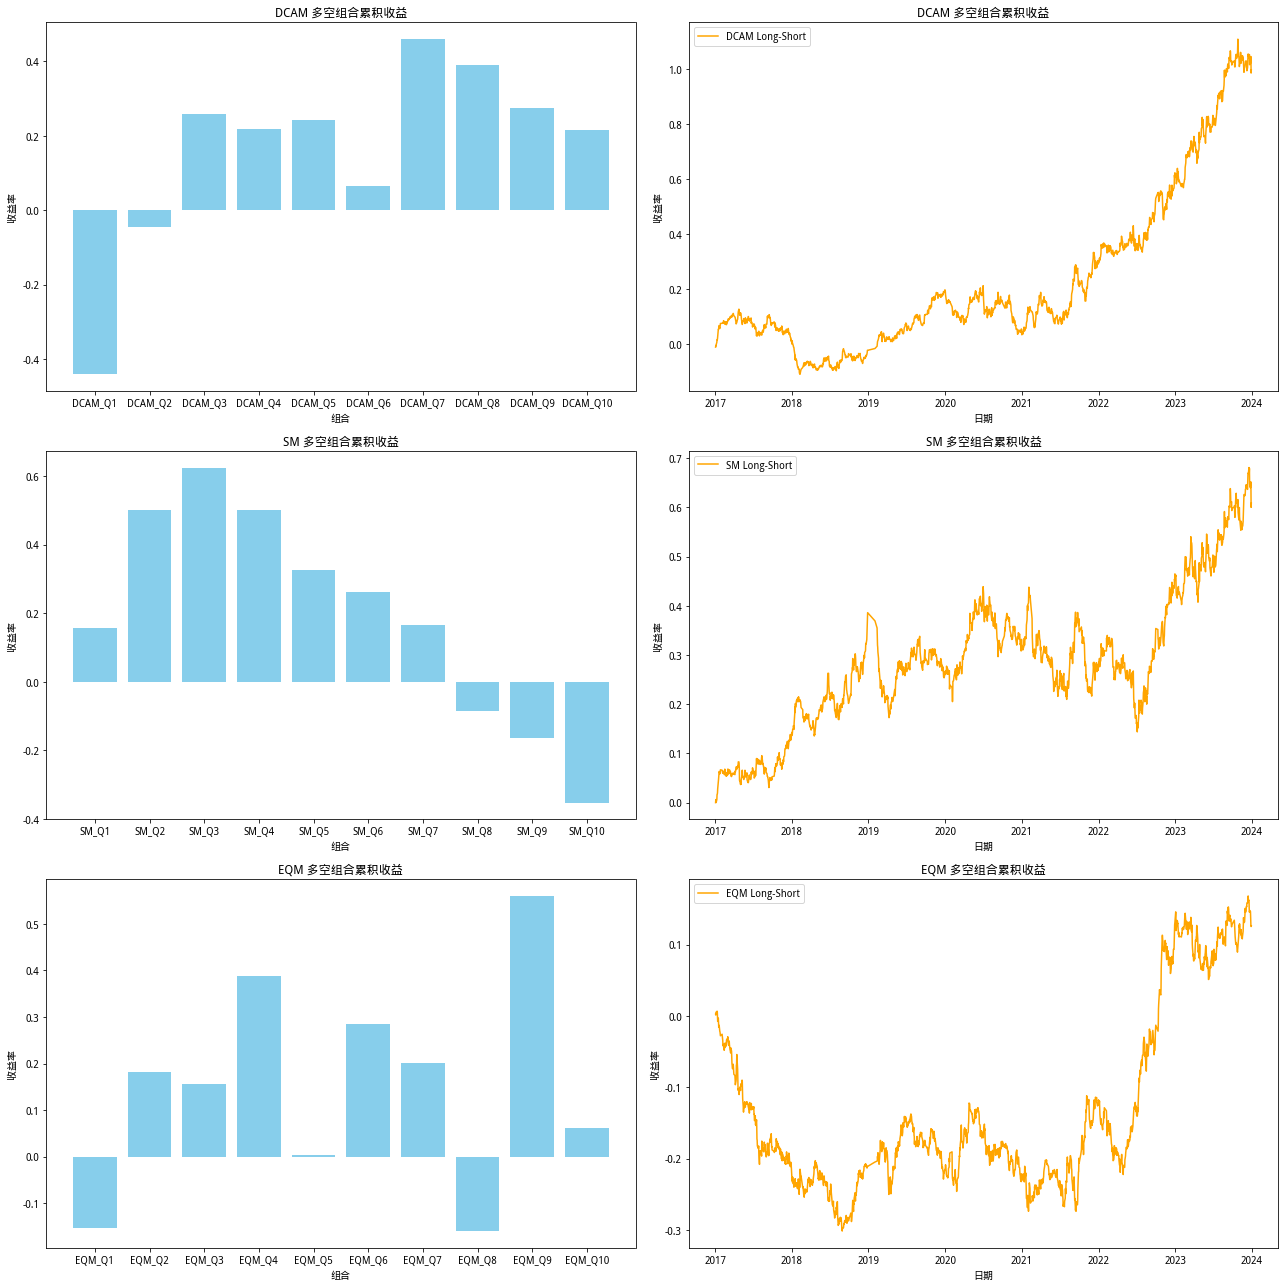

In [112]:
######################################### 执行脚本 ###################################################
plot_long_short("000905", start_date="2017-01-01", end_date="2023-12-30")

# 模型再思考 (DCAM_v2)

将以上模型记为 DCAM_v1，它在设计上尚有不足，首先，情景分区的选取尚有改进，将市值情景均分两份后大市值区间内市值差异依旧明显；其次在同一情景内简单的将不同情景区间的ZSCORE等同对待，忽视了 alpha/预期收益的差异性和平均水平；另外，不同情景间的加权方式值得商酌。

<center><img src="img/DCAM/动态情景模型基本架构.png" width="70%"></center>

## 模型重构

### 情景区间构建

我们在第一部分分析情景因子时提出选取情景因子的核心标准是其不同区间 alpha 模型的差异性，即该因子对股票收益影响因素的区分能力，结合我们之间的因子研究和学术界的成果，我们绝对采用市值（年日均总市值）、价值（年日均账面市值比）、成长（净资产同比增长率）三个维度作为情景因子，样本空间按照每个情景因子均分为 5 个情景区间。

In [2]:
######################################### 执行脚本 ###################################################
start_date = "20160131"
end_date = "20240331"
pre_start_day = ft.get_near_trade_day(start_date, -252*2)
cal = ft.get_calendar(start_date=pre_start_day, end_date=end_date, freq="M")
date_list = ft.get_calendar(start_date=start_date, end_date=end_date, freq="M")
factor_list = ["size", "book_to_price_ratio", "net_asset_growth_rate"]
file_path = "result/DCAM_v2/"
file_name = "fac_ret_dict.pkl"

if not os.path.exists(file_path+file_name):
    fac_ret_dict = ft.store_output(ft.get_fac_ret_dict, (cal, factor_list, "000985.XSHG", 5, True), file_name, file_path)
else:
    with open(os.path.join(file_path, file_name), "rb") as f:
        fac_ret_dict = pickle.load(f)

### Alpha因子选择

|因子名称|因子含义|
|---|---|
| share_turnover_monthly |股票一个月换手率|
| ROC120 | 120日变动速率 |
| earnings_to_price_ratio | 过去12个月的归母净利润除以当前股票市值 |
| ROAEBITTTM | 总资产报酬率 |
| cash_flow_to_price_ratio | 现金流市值比 |
| operating_revenue_growth_rate | 营业收入增长率 |
| net_profit_growth_rate | 净利润增长率 |

In [3]:
######################################### 执行脚本 ###################################################
alpha_list = ["share_turnover_monthly", "ROC120", "earnings_to_price_ratio", "ROAEBITTTM", 
              "cash_flow_to_price_ratio", "operating_revenue_growth_rate", "net_profit_growth_rate"]
file_path = "result/DCAM_v2/"
file_name = "alpha_ret_dict.pkl"
if not os.path.exists(file_path+file_name):
    alpha_fac_ret_dict = ft.store_output(ft.get_fac_ret_dict, (cal, alpha_list, "000985.XSHG", 5, True), file_name, file_path)
else:
    with open(os.path.join(file_path, file_name), "rb") as f:
        alpha_fac_ret_dict = pickle.load(f)
        
# 初始化变量
day = date_list[2]
ctxt_fac = factor_list[1]
label = 3

### 基础 alpha 模型

基础 alpha 模型部分我们采用经典的 IC_IR 加权的线性模型，具体做法如下，

**1. IC_IR 加权因子排名分位数获取 ZSCORE**

在单个情景区间中计算各个 alpha 因子过去 24 个月的风险调整 IC 的均值除以标准差作为各个 alpha 因子在情景区间分位数（采用分位数而不是因子值是因为单个情景区间内因子的分布可能有偏，和正态分布相差较大）的权重：

$$
w_k=\frac{\text{mean} (\text{IC_adj}_k)}{\text{std}(\text{IC_adj}_k)}
$$

也就是说，用alpha因子的区间分位数代替因子值。假设某个alpha因子的分位数序列为 $p=[p_1,p_2,\cdots,p_n]$，n为股票数量。

对于股票 $i$ 来说，其ZSCORE为

$$
ZSCORE_i=\frac{p_i-\bar{p}}{\sigma_p}
$$

**2. ZSCORE 转换为预期收益率**

在情景区间中，用个股的收益率对标准化后的 ZSCORE 做横截面上的线性回归，估计出单期的截距项 a 和系数项 b，然后取过去 12 个月的均值作为 a 和 b 的最新估值值，然后再将股票最新的 ZSCORE 带入下列方程计算该情景区间下各只股票的预期收益率

$$
ret_i=a+b\cdot ZSCORE_i
$$

In [4]:
def stratified_layers(day, _fac_ret_dict, _ctxt_fac, _alpha_fac_ret_dict):
    """
    获取单个情景空间内的股票
    
    params:
    - day: 日期
    - _fac_ret_dict: 情景因子字典
    - _ctxt_fac: 单个情景因子
    - _alpha_fac_ret_dict: Alpha因子字典
    
    return:
    - dict: {层级: 股票列表}
    """
    _alpha_fac = _alpha_fac_ret_dict[day].columns.tolist()
    end_idx = _alpha_fac.index(0)
    _alpha_fac = _alpha_fac[:end_idx]
    labels = np.arange(1, 6).tolist()
    stratify_dict = {}

    fac_df = _fac_ret_dict[day][_ctxt_fac]
    alpha_df = _alpha_fac_ret_dict[day]
    alpha_df = pd.concat([fac_df, alpha_df], axis=1, sort=True)
    alpha_df.dropna(inplace=True, axis=0)
    
    # 使用 np.linspace 将数据划分为5个区间
    alpha_df = alpha_df.sort_values(by=_ctxt_fac)
    alpha_df['label'] = pd.qcut(alpha_df[_ctxt_fac], q=5, labels=labels)
    
    for label in labels:
        stratify_dict[label] = alpha_df[alpha_df['label'] == label].index.tolist()
    
    return stratify_dict

In [5]:
# 示例
stratified_layers(day, fac_ret_dict, ctxt_fac, alpha_fac_ret_dict)[label][:10]

['002170.XSHE',
 '601238.XSHG',
 '002198.XSHE',
 '600967.XSHG',
 '002135.XSHE',
 '000566.XSHE',
 '601018.XSHG',
 '300289.XSHE',
 '000782.XSHE',
 '000678.XSHE']

In [6]:
def calculate_ic_ir(_fac_ret_dict):  #@save
    """
    计算ICIR(轻量级)
    性能好于factor_ic_test
    
    params: fac_ret_dict
    
    return: dataframe(index=因子名, columns=["IC_mean", "IC_std", "IC_IR"])
    """
    # 多层索引
    factors_df = pd.concat(_fac_ret_dict, axis=0).dropna(axis=0)
    filtered_cols = factors_df.columns[:(factors_df.columns.tolist().index(0)+1)]
    factors_df = factors_df[filtered_cols]
    factors_df.index.names = ['date', 'stock_code']
    
    def spearman_corr(group):
        # 删除全部值相同的序列（会导致std=nan）
        non_constant_cols = group.loc[:, group.apply(lambda x: x.nunique() > 1)]
        if non_constant_cols.shape[1] > 1:
            # 确保列数>=2
            return non_constant_cols.apply(lambda col: stats.spearmanr(col, group[0])[0])
        else:
            return pd.Series(np.nan, index=non_constant_cols.columns)

    # 用groupby计算IC
    ic_results = factors_df.groupby(level='date').apply(
        lambda df: spearman_corr(df.dropna())
    ).drop(columns=[0], errors='ignore')

    ic_mean_std = ic_results.agg(['mean', 'std']).rename(index={'mean': 'IC_mean', 'std': 'IC_std'}).T
    ic_mean_std["IC_IR"] = ic_mean_std["IC_mean"] / ic_mean_std["IC_std"]
    
    return ic_mean_std

In [7]:
# 示例
calculate_ic_ir(alpha_fac_ret_dict)

,IC_mean,IC_std,IC_IR
share_turnover_monthly,-0.077000,0.133197,-0.578086
ROC120,-0.038513,0.118087,-0.326143
earnings_to_price_ratio,0.032462,0.107848,0.301000
ROAEBITTTM,0.008296,0.102490,0.080942
cash_flow_to_price_ratio,0.005776,0.034455,0.167650
operating_revenue_growth_rate,0.000858,0.069350,0.012375
net_profit_growth_rate,0.004239,0.065005,0.065215


In [8]:
def get_alpha_weight(day, ctxt_fac, label, alpha_fac_ret_dict):
    """
    计算在单个情景区间中各个 alpha 因子的权重
    
    params:
    - day: 日期
    - ctxt_fac: 情景分层因子
    - label: 层级
    - alpha_fac_ret_dict: alpha因子字典
    - count: 用过去多少天的IC计算权重
    
    return:
    - list: 权重列表
    """
    stratify_dict = stratified_layers(day, fac_ret_dict, ctxt_fac, alpha_fac_ret_dict)
    stock_list = stratify_dict[label]

    # 计算过去24个月的风险调整 IC
    window = ft.get_calendar(end_date=day, count=252*2, freq="M")
    filtered_alpha_dict = {}
    for key in alpha_fac_ret_dict.keys():
        if key in window:
            filtered_alpha_dict[key] = alpha_fac_ret_dict[key].reindex(stock_list)
    ic_ir = calculate_ic_ir(filtered_alpha_dict)
    
    # 归一化
    ir_list = ic_ir["IC_IR"].values.tolist()
    l2_norm = np.linalg.norm(ir_list)
    weights = ir_list / l2_norm
    
    return weights

In [9]:
# 示例
get_alpha_weight(day, ctxt_fac, label, alpha_fac_ret_dict)

array([-0.30870162652524635, -0.8578653475925894, 0.23383667813942546,
       -0.16909635132057765, -0.25076965443066235, 0.14653807137958264,
       -0.03373954890596445])

In [10]:
def get_weighted_zscore(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict):
    """
    计算单个情景区间每只股票的ZSCORE得分
    
    由于get_alpha_weight获取了alpha因子IR作为权重, zscore与权重相乘后正负号已经调整过来
    
    params:
    - day: 日期
    - fac_ret_dict: 情景因子字典(数据源)
    - ctxt_fac: 单个情景因子
    - label: 层级
    - alpha_fac_ret_dict: alpha因子字典(数据源)
    """
    stratify_dict = stratified_layers(day, fac_ret_dict, ctxt_fac, alpha_fac_ret_dict)
    stock_list = stratify_dict[label]
    alpha_df = alpha_fac_ret_dict[day]
    _alpha_list = alpha_df.columns[:alpha_df.columns.tolist().index(0)]
    alpha_df = alpha_df.loc[stock_list, _alpha_list]
    alpha_pr_df = alpha_df.apply(lambda x: x.map(lambda value: stats.percentileofscore(x, value) / 100))
    alpha_weight = get_alpha_weight(day, ctxt_fac, label, alpha_fac_ret_dict)
    
    return alpha_pr_df.mul(alpha_weight, axis=1).sum(axis=1)

In [11]:
# 示例
get_weighted_zscore(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict).head()

code
002170.XSHE   -0.304444
601238.XSHG   -0.577303
002198.XSHE   -1.095810
600967.XSHG   -0.383720
002135.XSHE   -0.858825
dtype: float64

现在得到了加权的ZSCORE，下一步是在每个区间用ZSCORE和股票收益率做线性回归（样本为过去12个月，月频数据）。即每期做一个横截面回归，将过去12个月得到的回归系数取平均作为最终的估计 $\hat{a},\hat{b}$，它可以用来计算个股预期收益率。注意：回归要分区间进行，这里出现15个区间，意味着有15个回归模型。

这里埋伏一笔，原文中用的是最基本的线性回归，此处可以尝试用其他机器学习方法。

In [12]:
def ret_zscore_reg(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict):
    """
    对个股收益率和ZSCORE线性回归
    
    params:
    - day: 日期
    - fac_ret_dict: 情景因子字典(数据源)
    - ctxt_fac: 单个情景因子
    - label: 层级
    - alpha_fac_ret_dict: alpha因子字典(数据源)
    
    return:
    - a: 截距项
    - b: 斜率
    """
    zscore = get_weighted_zscore(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict)
    return_df = alpha_fac_ret_dict[day][0].reindex(zscore.index)
    X = zscore.values.reshape(-1, 1)
    y = return_df.values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, y)
    a = model.intercept_[0]  # 截距项
    b = model.coef_[0][0]   # 斜率
    
    return a, b

In [13]:
# 示例
ret_zscore_reg(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict)

(-0.00892685593642456, -0.00970467203653347)

In [14]:
def reg_window_coef(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict):
    """
    获得对过去12个月数据做回归的系数
    
    params:
    - day: 日期
    - fac_ret_dict: 情景因子字典(数据源)
    - ctxt_fac: 单个情景因子
    - label: 层级
    - alpha_fac_ret_dict: alpha因子字典(数据源)
    
    return:
    - a截距项, b斜率
    """
    _cal = ft.get_calendar(end_date=day, count=252, freq="M")
    min_day = min(list(alpha_fac_ret_dict.keys()))
    assert _cal[0] >= min_day, "date time overflow"

    a_list = []
    b_list = []
    
    # 已知数据截至前一天, 避免数据窥探
    for day in _cal[:-1]:
        a, b = ret_zscore_reg(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict)
        a_list.append(a)
        b_list.append(b)
        
    return np.mean(a_list), np.mean(b_list)

In [15]:
# 示例
ft.log_print("Start")
print(reg_window_coef(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict))
ft.log_print("Finished")

[2024-10-06 20:05:09] Start
(0.04137425739136164, 0.03186576482446681)
[2024-10-06 20:05:13] Finished


### 情景间 alpha 加权

前文alpha的IC_IR加权评判alpha因子的好坏，此处加权评判情景因子的好坏。

前文的分析中我们建议采用该情景下不同情景区间的模型区分度作为情景间预期收益率的权重，对于线性模型，我们定义如下两个模型的距离如下：

$$
d_{i,j}=\sqrt{\frac 1K \sum_{k=1}^K (w_k^i-w_k^j)^2}
$$

$d_{i,j}$ 模型 $i$ 和模型 $j$ 间的距离，$K$ 为 alpha 因子的个数。

我们定义同一情景因子下 5 个情景区间的模型两两距离均值为该情景的情景区分度，并以此为权重加权个股在各个情景下的预期收益率。

In [16]:
def ctxt_distance_v2(day, alpha_fac_ret_dict):
    """
    计算情景区分度
    
    params:
    - day: 日期
    - alpha_fac_ret_dict: alpha因子字典
    
    return:
    - 情景区分度向量
    """
    ctxt_weights = []
    for ctxt_fac in factor_list:
        alpha_weights = []
        for label in [1,2,3,4,5]:
            w = get_alpha_weight(day, ctxt_fac, label, alpha_fac_ret_dict)
            alpha_weights.append(w)
        alpha_weights_df = pd.DataFrame(alpha_weights, columns=alpha_list, index=[1,2,3,4,5])
        alpha_weights_array = alpha_weights_df.values
        diff = alpha_weights_array[:, np.newaxis, :] - alpha_weights_array[np.newaxis, :, :]
        d_ijs = np.sqrt(np.mean(diff ** 2, axis=2)) # shape: (5,5)
        ctxt_w = np.mean(d_ijs[np.triu_indices_from(d_ijs, k=1)])
        ctxt_weights.append(ctxt_w)
    
    # 归一化
    normalized_weights = ctxt_weights / np.sum(ctxt_weights)
    
    return normalized_weights

In [17]:
# 示例
ft.log_print("Start")
print(ctxt_distance_v2(day, alpha_fac_ret_dict))
ft.log_print("Finished")

[2024-10-06 20:05:13] Start
[0.3796029299651287 0.299408854629532 0.32098821540533923]
[2024-10-06 20:05:18] Finished


### 计算个股综合得分

计算步骤如下

1. 在每个调仓日, 在每个情景下分区间计算股票的综合得分ZSCORE(利用get_weighted_zscore函数)
2. 用ZSCORE作为自变量基于历史数据拟合线性模型, 获得参数(reg_window_coef函数)
3. 抓取当期ZSCORE(get_weighted_zscore函数), 用拟合的参数计算预期收益率
4. 每只股票在每个情景下都有个预期收益率, 合并, 剔除有缺失值的股票, 对预期收益率加权(ctxt_distance_v2函数)再相加, 作为得分
5. 将综合得分从大到小排序, 分为10组. 做多第一组, 做空第十组

In [18]:
def get_comp_score_v2(day, fac_ret_dict, alpha_fac_ret_dict):
    """
    DCAM_v2模型个股综合得分
    
    params:
    - day: 日期
    - fac_ret_dict: 情景因子字典
    - alpha_fac_ret_dict: alpha因子字典
    
    return:
    - pd.Series: 个股综合得分(加权预期收益率)
    """
    ctxt_list = []
    fac_df = fac_ret_dict[day]
    factor_list = fac_df.columns[:fac_df.columns.tolist().index(0)]
    for ctxt_fac in factor_list:
        ft.log_print(f"情景: {ctxt_fac}")
        # 在单个情景下的不同情景区间
        ctxt_label_list = []
        for label in [1,2,3,4,5]:
            zscore = get_weighted_zscore(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict)
            a, b = reg_window_coef(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict)
            pred_return = a + b * zscore
            ctxt_label_list.append(pred_return)

        ctxt_df = pd.concat(ctxt_label_list)
        ctxt_list.append(ctxt_df)
    
    # 合并不同情景下个股的得分
    all_stocks = ctxt_list[0].index.union(ctxt_list[1].index).union(ctxt_list[2].index)
    reindexed_ctxt_list = [s.reindex(all_stocks) for s in ctxt_list]
    all_ctxt_df = pd.concat(reindexed_ctxt_list, axis=1)
    all_ctxt_df.columns = factor_list
    all_ctxt_df.dropna(inplace=True, axis=0)
    
    # 对情景间加权
    ctxt_weights = ctxt_distance_v2(day, alpha_fac_ret_dict)
    
    return np.sum(all_ctxt_df * ctxt_weights, axis=1)

In [19]:
# 示例
ft.log_print("Start")
score_df = get_comp_score_v2(day, fac_ret_dict, alpha_fac_ret_dict)
ft.log_print("Finished")
score_df.head()

[2024-10-06 20:05:18] Start
[2024-10-06 20:05:18] 情景: size
[2024-10-06 20:05:38] 情景: book_to_price_ratio
[2024-10-06 20:05:59] 情景: net_asset_growth_rate
[2024-10-06 20:06:24] Finished


code
000001.XSHE    0.010999
000005.XSHE    0.026455
000006.XSHE    0.022063
000008.XSHE    0.012140
000009.XSHE    0.005139
dtype: float64

## DCAM_v2 模型回测

与第一部分的步骤相同, 先把打分结果放进 data_dict_v2, 计算IC指标. 然后仿照 long_short函数写出 long_short_v2函数评估多空组合绩效.

### IC指标计算

In [21]:
def get_score_dict_v2(date_list):
    data_dict_v2 = {}
    for i in range(len(date_list)-1):
        day = date_list[i]
        ft.log_print(f"调仓日: {day}")
        
        # 加载因子字典
        with open(f"result/DCAM_v2/alpha_ret_dict.pkl", "rb") as f:
            alpha_fac_ret_dict = pickle.load(f)
        with open(f"result/DCAM_v2/fac_ret_dict.pkl", "rb") as f:
            fac_ret_dict = pickle.load(f)
            
        # DCAM_v2
        DCAM_v2 = get_comp_score_v2(day, fac_ret_dict, alpha_fac_ret_dict)

        # SM
        delta_idx = list(alpha_fac_ret_dict.keys()).index(date_list[0])
        keys = list(alpha_fac_ret_dict.keys())[i:i+delta_idx]
        tmp_alpha_dict = {key: alpha_fac_ret_dict[key] for key in keys if key in alpha_fac_ret_dict}
        ic_mean_std = ft.calculate_ic_ir(tmp_alpha_dict)
        alpha_df = alpha_fac_ret_dict.get(day)
        alpha_list = alpha_df.columns[:alpha_df.columns.tolist().index(0)]
        alpha_df = alpha_df[alpha_list]
        weighted_df = alpha_df.mul(ic_mean_std["IC_IR"], axis=1)
        SM = weighted_df.sum(axis=1).reindex(DCAM_v2.index)

        # 股票下期收益率
        ret_df = alpha_fac_ret_dict[day][0].reindex(DCAM_v2.index)

        comp_df = pd.concat([DCAM_v2, SM, ret_df], axis=1).dropna(axis=0)
        comp_df.columns = ["DCAM_v2", "SM", 0]

        data_dict_v2[day] = comp_df
    
    return data_dict_v2

In [22]:
######################################### 执行脚本 ###################################################
root = "result/DCAM_v2/"
filename = "data_dict_v2.pkl"
if not os.path.exists(root+filename):
    data_dict_v2 = ft.store_output(get_score_dict_v2, date_list, filename, root)
else:
    with open(root+filename, "rb") as f:
        data_dict_v2 = pickle.load(f)
        
IC_mean_std = ft.calculate_ic_ir(data_dict_v2)
IC_mean_std

[2024-10-06 20:09:22] 调仓日: 2016-02-29 00:00:00
[2024-10-06 20:09:23] 情景: size
[2024-10-06 20:09:42] 情景: book_to_price_ratio
[2024-10-06 20:10:02] 情景: net_asset_growth_rate
[2024-10-06 20:10:27] 调仓日: 2016-03-31 00:00:00
[2024-10-06 20:10:27] 情景: size
[2024-10-06 20:10:47] 情景: book_to_price_ratio
[2024-10-06 20:11:08] 情景: net_asset_growth_rate
[2024-10-06 20:11:33] 调仓日: 2016-04-29 00:00:00
[2024-10-06 20:11:34] 情景: size
[2024-10-06 20:11:55] 情景: book_to_price_ratio
[2024-10-06 20:12:16] 情景: net_asset_growth_rate
[2024-10-06 20:12:41] 调仓日: 2016-05-31 00:00:00
[2024-10-06 20:12:41] 情景: size
[2024-10-06 20:13:03] 情景: book_to_price_ratio
[2024-10-06 20:13:24] 情景: net_asset_growth_rate
[2024-10-06 20:13:50] 调仓日: 2016-06-30 00:00:00
[2024-10-06 20:13:50] 情景: size
[2024-10-06 20:14:12] 情景: book_to_price_ratio
[2024-10-06 20:14:34] 情景: net_asset_growth_rate
[2024-10-06 20:15:01] 调仓日: 2016-07-29 00:00:00
[2024-10-06 20:15:01] 情景: size
[2024-10-06 20:15:23] 情景: book_to_price_ratio
[2024-10-06 20:1

[2024-10-06 21:09:19] 情景: net_asset_growth_rate
[2024-10-06 21:09:49] 调仓日: 2020-02-28 00:00:00
[2024-10-06 21:09:49] 情景: size
[2024-10-06 21:10:13] 情景: book_to_price_ratio
[2024-10-06 21:10:38] 情景: net_asset_growth_rate
[2024-10-06 21:11:08] 调仓日: 2020-03-31 00:00:00
[2024-10-06 21:11:08] 情景: size
[2024-10-06 21:11:33] 情景: book_to_price_ratio
[2024-10-06 21:11:58] 情景: net_asset_growth_rate
[2024-10-06 21:12:28] 调仓日: 2020-04-30 00:00:00
[2024-10-06 21:12:28] 情景: size
[2024-10-06 21:12:52] 情景: book_to_price_ratio
[2024-10-06 21:13:17] 情景: net_asset_growth_rate
[2024-10-06 21:13:46] 调仓日: 2020-05-29 00:00:00
[2024-10-06 21:13:47] 情景: size
[2024-10-06 21:14:11] 情景: book_to_price_ratio
[2024-10-06 21:14:36] 情景: net_asset_growth_rate
[2024-10-06 21:15:06] 调仓日: 2020-06-30 00:00:00
[2024-10-06 21:15:06] 情景: size
[2024-10-06 21:15:31] 情景: book_to_price_ratio
[2024-10-06 21:15:56] 情景: net_asset_growth_rate
[2024-10-06 21:16:26] 调仓日: 2020-07-31 00:00:00
[2024-10-06 21:16:26] 情景: size
[2024-10-06 21

[2024-10-06 22:15:08] 情景: book_to_price_ratio
[2024-10-06 22:15:35] 情景: net_asset_growth_rate
[2024-10-06 22:16:07] 调仓日: 2024-02-29 00:00:00
[2024-10-06 22:16:07] 情景: size
[2024-10-06 22:16:35] 情景: book_to_price_ratio
[2024-10-06 22:17:02] 情景: net_asset_growth_rate
[2024-10-06 22:17:35] Output stored in result/DCAM_v2/data_dict_v2.pkl


,IC_mean,IC_std,IC_IR
DCAM_v2,0.091056,0.110334,0.825271
SM,0.064677,0.109300,0.591740


### 多空组合测试

In [21]:
def long_short(rebalance_dict, model_names):
    """
    计算分组收益率和多空组合绩效
    """
    # 存储每个组合的日频收益率
    daily_portfolio_returns = None

    with open(f"result/DCAM_v2/alpha_ret_dict.pkl", "rb") as f:
        alpha_fac_ret_dict = pickle.load(f)
    
    IC_mean_std = ft.calculate_ic_ir(rebalance_dict)

    portfolio_ret_list = []
    for rebalance_date, scores_df in rebalance_dict.items():
#         if rebalance_date.month == 12:
#             ft.log_print(f"调仓日：{rebalance_date}")
        daily_portfolio_returns = None
        for model in model_names:
            # 按照每个模型的打分对股票进行排序
            model_scores_df = scores_df.sort_values(by=model, ascending=False)

            # 构建10个等权组合
            n_stocks = len(model_scores_df)
            group_size = n_stocks // 10
            portfolios = {}
            for i in range(10):
                portfolios[f'{model}_Q{i+1}'] = model_scores_df.index[i*group_size:(i+1)*group_size]

            # 获取调仓日至下一个调仓日之间的日期范围
            next_rebalance_date = min([date for date in rebalance_dict.keys() if date > rebalance_date], default=date_list.max())

            # 获取调仓日至下一个调仓日之间的收盘价数据
            security = alpha_fac_ret_dict[rebalance_date].index.tolist()
            price_data = get_price(security, start_date=rebalance_date, end_date=next_rebalance_date, fields=["close"], panel=False)
            price_data["ret"] = price_data.groupby("code")["close"].pct_change()
            daily_returns = price_data.pivot(index='time', columns='code', values='ret').dropna()

            holding_period = daily_returns.loc[rebalance_date:next_rebalance_date].index

            if daily_portfolio_returns is None:
                daily_portfolio_returns = pd.DataFrame(index=daily_returns.index)

            # 计算每个组合在持有期内的日收益率
            for portfolio_name, stocks in portfolios.items():
                portfolio_returns = daily_returns[stocks].loc[holding_period].mean(axis=1)
                daily_portfolio_returns.loc[holding_period, portfolio_name] = portfolio_returns

            # 计算多空组合的日收益率
            daily_portfolio_returns.loc[holding_period, f'{model}_long_short'] = (
                daily_portfolio_returns.loc[holding_period, f'{model}_Q1'] - daily_portfolio_returns.loc[holding_period, f'{model}_Q10']
            ) * np.where(IC_mean_std.loc[model]["IC_mean"] > 0, 1, -1)

        portfolio_ret_list.append(daily_portfolio_returns)
    portfolio_ret = pd.concat(portfolio_ret_list)
    
    return portfolio_ret

def plot_long_short_v2(portfolio_ret, col_name):
    # 计算累积收益率
    daily_cumulative_returns = (1 + portfolio_ret).cumprod() - 1

    # 作图
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # 每个模型的十个组合的累积收益率柱状图和多空组合收益率曲线图
    for i, model in enumerate(col_name):
        # 十个组合的累积收益率柱状图
        cumulative_returns = daily_cumulative_returns[[f'{model}_Q{i+1}' for i in range(10)]].iloc[-1]
        axes[i, 0].bar([f'{model}_Q{i+1}' for i in range(10)], cumulative_returns, color='skyblue')
        axes[i, 0].set_title(f'{model} 多空组合累积收益')
        axes[i, 0].set_ylabel('收益率')
        axes[i, 0].set_xlabel('组合')

        # 多空组合收益率曲线图
        if f'{model}_long_short' in daily_cumulative_returns.columns:
            axes[i, 1].plot(daily_cumulative_returns.index, daily_cumulative_returns[f'{model}_long_short'], label=f'{model} Long-Short', color='orange')
            axes[i, 1].set_title(f'{model} 多空组合累积收益')
            axes[i, 1].set_ylabel('收益率')
            axes[i, 1].set_xlabel('日期')
            axes[i, 1].legend()

    plt.tight_layout()
    plt.show()

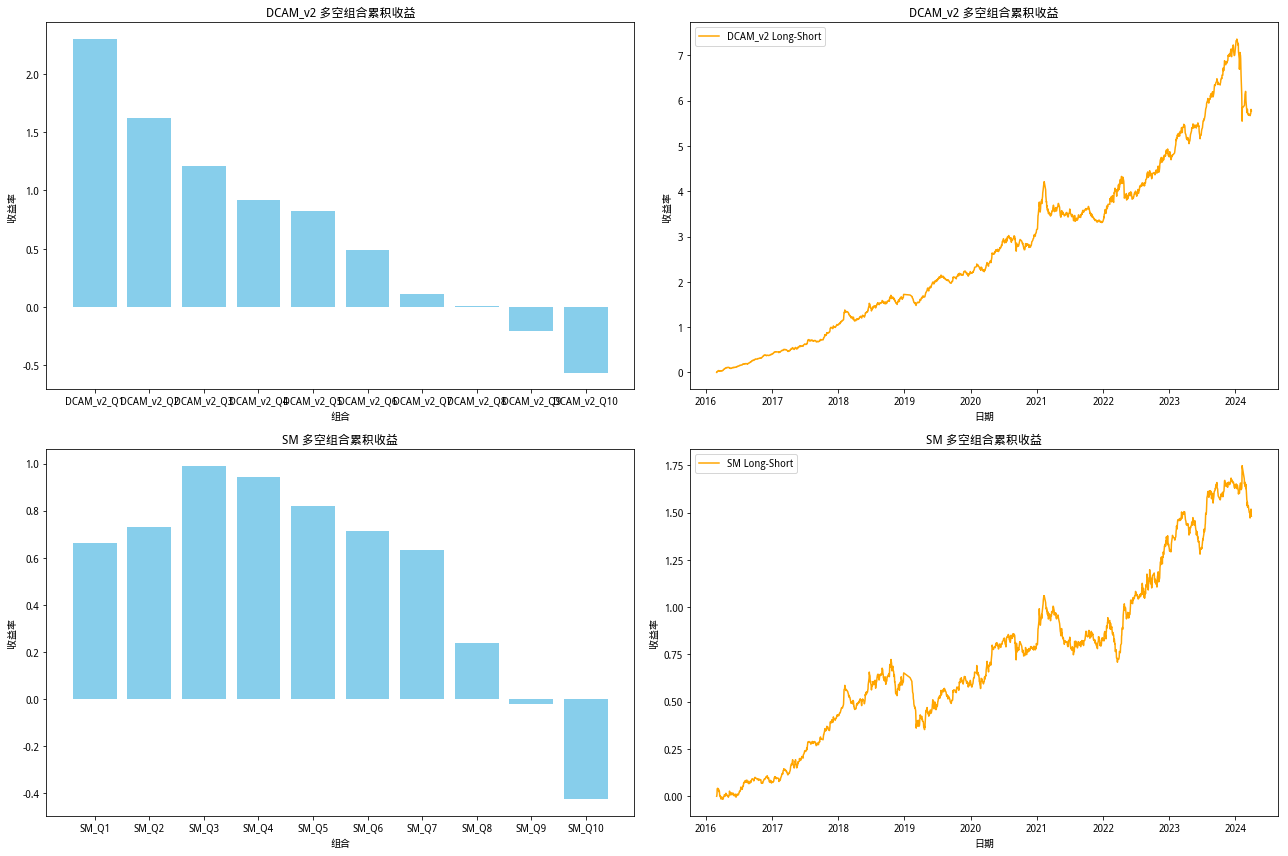

In [22]:
######################################### 执行脚本 ###################################################
root = "result/DCAM_v2/"
filename = "long_short_v2.pkl"
if not os.path.exists(root+filename):
    portfolio_ret = store_output(long_short, (data_dict_v2, ['DCAM_v2', 'SM']), filename, root)
else:
    with open(root+filename, "rb") as f:
        portfolio_ret = pickle.load(f)

plot_long_short_v2(portfolio_ret, ["DCAM_v2", "SM"])

计算相关指标

- 年化收益率
- 月度胜率
- 夏普率
- 最大回撤

In [16]:
def annualized_return(df):
    cumulative_returns = (1 + df).prod() - 1
    n_periods = df.shape[0]
    return (1 + cumulative_returns) ** (252 / n_periods) - 1

# Monthly Win Rate
def monthly_win_rate(df):
    monthly_returns = df.resample('M').apply(lambda x: (1 + x).prod() - 1)
    win_rate = (monthly_returns > 0).mean()
    return win_rate

# Sharpe Ratio
def sharpe_ratio(df, risk_free_rate=0.03):
    excess_returns = df.mean() * 252 - risk_free_rate
    annualized_volatility = df.std() * np.sqrt(252)
    return excess_returns / annualized_volatility

# Maximum Drawdown
def max_drawdown(df):
    cumulative_returns = (1 + df).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max
    return drawdown.min()

# Summary
def portfolio_summary(df):
    annual_returns = annualized_return(df)
    monthly_win_rates = monthly_win_rate(df)
    sharpe_ratios = sharpe_ratio(df)
    max_drawdowns = max_drawdown(df)

    results_df = pd.DataFrame({
        'Annualized Return': annual_returns,
        'Monthly Win Rate': monthly_win_rates,
        'Sharpe Ratio': sharpe_ratios,
        'Max Drawdown': max_drawdowns
    })

    results_df.index.name = 'Portfolio'
    return results_df

In [17]:
######################################### 执行脚本 ###################################################
df = portfolio_ret[["DCAM_v2_long_short", "SM_long_short"]]
portfolio_summary(df)

,Annualized Return,Monthly Win Rate,Sharpe Ratio,Max Drawdown
Portfolio,,,,
DCAM_v2_long_short,0.281173,0.752577,1.856214,-0.216768
SM_long_short,0.124894,0.659794,0.844812,-0.215346


### Fama-MacBeth资产定价检验

为了检验 DCAM 模型和 SM 模型之间的相互替代作用，检验分两步进行：

在第一个回归中，因变量为个股的下期的月收益率，自变量包括期初的 Beta, 市值对数 Size, SM模型的得分，动态模型的残差得分(每个月用动态模型的得分对静态模型得分回归，得到残差)。这种方法可以在控制静态模型的基础上，检验动态模型有没有增加额外的信息。

在第二个回归中，因变量仍然保持不变，自变量包括初的 Beta, 市值对数 Size, SM 模型的残差得分(每个月用静态模型的得分对动态模型得分回归，得到残差)，动态模型的得分。这种方法可以在控制动态模型的基础上，检验静态模型有没有增加额外的信息。

**第一个回归**

首先计算动态模型的残差(Res_DCAM)

$$
DCAM_{i,t}=\alpha_t+\beta_t\times SM_{i,t}+\varepsilon_{i,t}
$$

$$
Res\_DCAM_{i,t}=\varepsilon_{i,t}=DCAM_{i,t}-(\alpha_t+\beta_t\times SM_{i,t})
$$

Res_DCAM就表示DCAM相对于SM带来的增量信息, 因为作为误差项它是因变量(SM)无法解释的部分. 接下来做截面回归, 这是Fama MacBeth比较重要的一步

$$
R_{i,t}=\gamma_{0,t}+\gamma_{1,t}\cdot Beta_{i,t}+\gamma_{2,t}\cdot \log(Size_{i,t})+\gamma_{3,t}\cdot SM_{i,t}+\gamma_{4,t}\cdot Res\_DCAM_{i,t}+u_{i,t}
$$

每个月都做一次这样的截面回归, 样本是月末所有股票. 关注 $\gamma_{4,t}$, 它如果显著为正则说明 DCAM 模型相对原本的 SM 模型带来了有用的增益信息. 于是, 我们对 $\gamma_{4,t}$ 构建统计量

$$
\gamma_4 = \frac 1N \sum_{t=1}^N \gamma_{4,t}\quad N=12 \text{ months}
$$

**第二个回归**

同理, 只不过将DCAM和SM低位颠倒

$$
SM_{i,t}=\alpha_t+\beta_t\times DCAM_{i,t}+\varepsilon_{i,t}
$$

$$
Res\_DCAM_{i,t}=\varepsilon_{i,t}'=DCAM_{i,t}-(\alpha_t'+\beta_t'\times SM_{i,t})
$$

截面回归

$$
R_{i,t}=\delta_{0,t}+\gamma_{1,t}\cdot Beta_{i,t}+\delta_{2,t}\cdot \log(Size_{i,t})+\delta_{3,t}\cdot Res\_SM_{i,t}+\delta_{4,t}\cdot DCAM_{i,t}+v_{i,t}
$$

对时序的 $\delta_{3,t}$ 取平均

$$
\delta_3=\frac 1N \sum_{t=1}^N \delta_{3,t}
$$

现在对 $\gamma_4, \delta_3$ 做 hypothesis testing

H0: $\bar{\beta}=0$

H1: $\bar{\beta}\neq 0$

其中 $\bar{\beta}=\gamma_4, \delta_3$

接着计算标准误

$$
SE(\bar{\beta})=\frac{1}{\sqrt N}\sqrt{\frac{1}{N-1}\sum_{t=1}^N(\beta_t-\bar{\beta})^2}
$$

这样写假设了 $\beta_t$ 不存在自相关, 但显然是与现实背离的. 因此一般用 Newey-West 标准误

$$
SE_{NW}(\bar{\beta})=\sqrt{\frac{1}{N^2}\left(\sum_{t=1}^N e_t^2+2\sum_{l=1}^L w_l\sum_{t=l+1}^N e_te_{t-l}\right)}
$$

- $e_t=\beta_t-\bar{\beta}$
- $w_l=1-\frac{l}{L+1}$
- $L$ 是lag的个数 (经验法则: $L=0.75N^{1/3}$)

计算t统计量

$$
t_{\bar{\beta}}=\frac{\bar{\beta}}{SE_{NW}(\bar{\beta})}
$$

In [18]:
def compute_residuals(y, X):  #@save
    """
    计算残差项
    """
    X = add_constant(X)
    model = OLS(y, X).fit()
    residuals = model.resid
    return residuals

def cross_sectional_regression(df, dep_var, indep_vars):  #@save
    """
    截面回归
    """
    X = df[indep_vars]
    X = add_constant(X)
    y = df[dep_var]
    model = OLS(y, X).fit()
    return model.params, model.tvalues

def process_date(date_df_tuple):  #@save
    """
    Fama MacBeth主函数
    
    params:
    - tuple: (date, df)
    
    若数据源为字典, 可用 dict.items() 转换为以上格式
    """
    day, df = date_df_tuple
    assert 0 in df.columns, f"return column (0) is missing for date {day}"
    
    # Step 1: DCAM-SM回归, 计算残差项
    df.loc[:, 'Res_DCAM'] = compute_residuals(df['DCAM_v2'], df['SM'])
    
    # Step 2: 截面回归
    params_gamma, tvalues_gamma = cross_sectional_regression(
        df,
        dep_var=0,
        indep_vars=['beta', 'size', 'SM', 'Res_DCAM']
    )

    gamma_results = {'gamma_' + key: value for key, value in params_gamma.items()}
    gamma_tvalues = {'gamma_t_' + key: value for key, value in tvalues_gamma.items()}
    
    # Step 3: SM-DCAM回归, 计算残差项
    df.loc[:, 'Res_SM'] = compute_residuals(df['SM'], df['DCAM_v2'])
    
    # Step 4: 截面回归
    params_delta, tvalues_delta = cross_sectional_regression(
        df,
        dep_var=0,
        indep_vars=['beta', 'size', 'Res_SM', 'DCAM_v2']
    )

    delta_results = {'delta_' + key: value for key, value in params_delta.items()}
    delta_tvalues = {'delta_t_' + key: value for key, value in tvalues_delta.items()}
    
    # 汇总
    results = {'date': day}
    results.update(gamma_results)
    results.update(gamma_tvalues)
    results.update(delta_results)
    results.update(delta_tvalues)
    return results

def fm_summary(results_df):
    """
    Fama MacBeth回归结果
    
    params:
    - results_df: 对所有时间点都进行截面回归后汇总的dataframe
    """
    # 正则表达式选出系数(排除t值)
    gamma_coeffs = results_df.filter(regex='^gamma_(?!t_)')
    delta_coeffs = results_df.filter(regex='^delta_(?!t_)')

    # 均值
    gamma_mean = gamma_coeffs.mean()
    delta_mean = delta_coeffs.mean()

    # 标准误
    gamma_se = gamma_coeffs.std(ddof=1) / np.sqrt(len(gamma_coeffs))
    delta_se = delta_coeffs.std(ddof=1) / np.sqrt(len(delta_coeffs))

    # t-statistics
    gamma_t_stats = gamma_mean / gamma_se
    delta_t_stats = delta_mean / delta_se

    # 汇总
    gamma_summary = pd.DataFrame({
        'Coefficient': gamma_mean,
        'Std_Error': gamma_se,
        't_Statistic': gamma_t_stats
    })

    delta_summary = pd.DataFrame({
        'Coefficient': delta_mean,
        'Std_Error': delta_se,
        't_Statistic': delta_t_stats
    })

    summary_df = pd.concat([gamma_summary.T, delta_summary.T], axis=1)
    layers = ["gamma"] * gamma_summary.shape[0] + ["delta"] * delta_summary.shape[0]
    updated_cols = summary_df.columns.str.replace(r'^(gamma_|delta_)', '', regex=True)
    new_cols = pd.MultiIndex.from_arrays([layers, updated_cols])
    summary_df.columns = new_cols
    
    return summary_df

In [19]:
######################################### 执行脚本 ###################################################
root = "result/DCAM_v2/"
if not os.path.exists(root+"fm_dict.pkl"):
    ft.log_print("Start fm_dict")
    fm_dict = {}
    for key in data_dict_v2.keys():
        tmp_df = data_dict_v2[key]
        fm_fac = get_factor_values(tmp_df.index.tolist(), ["beta", "size"], end_date=day, count=1)
        tmp_df["beta"] = fm_fac["beta"].T
        tmp_df["size"] = fm_fac["size"].T
        fm_dict[key] = tmp_df.dropna(axis=0)
    with open(root+"fm_dict.pkl", 'wb') as f:
        pickle.dump(fm_dict, f)
    ft.log_print("Finished")
else:
    with open(root+"fm_dict.pkl", "rb") as f:
        fm_dict = pickle.load(f)

if not os.path.exists(root+"fm_results_df.pkl"):
    ft.log_print("Start results_df")
    results = list(map(process_date, fm_dict.items()))
    results_df = pd.DataFrame(results)
    results_df.set_index('date', inplace=True)
    with open(root+"fm_results_df.pkl", 'wb') as f:
        pickle.dump(results_df, f)
    ft.log_print("Finished")
else:
    with open(root+"fm_results_df.pkl", "rb") as f:
        results_df = pickle.load(f)

summary_df = fm_summary(results_df)
summary_df

gamma              ...        delta          
             Res_DCAM        SM    ...        const      size
Coefficient  1.152356  0.003189    ...    -0.003393  0.000275
Std_Error    0.202061  0.000746    ...     0.005779  0.001156
t_Statistic  5.703014  4.277667    ...    -0.587055  0.237764

[3 rows x 10 columns]

注意到 Res_DCAM 的系数为正在 1% 上显著, 而 Res_SM 的系数显著为负. 由此说明 DCAM_v2 模型相对于 SM 模型确实给出了有效的增量信息

# SVR预测收益率 (DCAM_v3)

## 模型函数

In [4]:
######################################### 执行脚本 ###################################################
start_date = "20160131"
end_date = "20240331"
pre_start_day = ft.get_near_trade_day(start_date, -252*2)
cal = ft.get_calendar(start_date=pre_start_day, end_date=end_date, freq="M")
date_list = ft.get_calendar(start_date=start_date, end_date=end_date, freq="M")
factor_list = ["size", "book_to_price_ratio", "net_asset_growth_rate"]
file_path = "result/DCAM_v2/"
file_name = "fac_ret_dict.pkl"

if not os.path.exists(file_path+file_name):
    fac_ret_dict = ft.store_output(ft.get_fac_ret_dict, (cal, factor_list, "000985.XSHG", 5, True), file_name, file_path)
else:
    with open(os.path.join(file_path, file_name), "rb") as f:
        fac_ret_dict = pickle.load(f)

alpha_list = ["share_turnover_monthly", "ROC120", "earnings_to_price_ratio", "ROAEBITTTM", 
              "cash_flow_to_price_ratio", "operating_revenue_growth_rate", "net_profit_growth_rate"]
file_path = "result/DCAM_v2/"
file_name = "alpha_ret_dict.pkl"
if not os.path.exists(file_path+file_name):
    alpha_fac_ret_dict = ft.store_output(ft.get_fac_ret_dict, (cal, alpha_list, "000985.XSHG", 5, True), file_name, file_path)
else:
    with open(os.path.join(file_path, file_name), "rb") as f:
        alpha_fac_ret_dict = pickle.load(f)

In [3]:
def stratified_layers(day, _fac_ret_dict, _ctxt_fac, _alpha_fac_ret_dict):
    """
    获取单个情景空间内的股票
    
    params:
    - day: 日期
    - _fac_ret_dict: 情景因子字典
    - _ctxt_fac: 单个情景因子
    - _alpha_fac_ret_dict: Alpha因子字典
    
    return:
    - dict: {层级: 股票列表}
    """
    _alpha_fac = _alpha_fac_ret_dict[day].columns.tolist()
    end_idx = _alpha_fac.index(0)
    _alpha_fac = _alpha_fac[:end_idx]
    labels = np.arange(1, 6).tolist()
    stratify_dict = {}

    fac_df = _fac_ret_dict[day][_ctxt_fac]
    alpha_df = _alpha_fac_ret_dict[day]
    alpha_df = pd.concat([fac_df, alpha_df], axis=1, sort=True)
    alpha_df.dropna(inplace=True, axis=0)
    
    # 使用 np.linspace 将数据划分为5个区间
    alpha_df = alpha_df.sort_values(by=_ctxt_fac)
    alpha_df['label'] = pd.qcut(alpha_df[_ctxt_fac], q=5, labels=labels)
    
    for label in labels:
        stratify_dict[label] = alpha_df[alpha_df['label'] == label].index.tolist()
    
    return stratify_dict

In [5]:
def get_alpha_weight(day, ctxt_fac, label, alpha_fac_ret_dict):
    """
    计算在单个情景区间中各个 alpha 因子的权重
    
    params:
    - day: 日期
    - ctxt_fac: 情景分层因子
    - label: 层级
    - alpha_fac_ret_dict: alpha因子字典
    - count: 用过去多少天的IC计算权重
    
    return:
    - list: 权重列表
    """
    stratify_dict = stratified_layers(day, fac_ret_dict, ctxt_fac, alpha_fac_ret_dict)
    stock_list = stratify_dict[label]

    # 计算过去24个月的风险调整 IC
    window = ft.get_calendar(end_date=day, count=252*2, freq="M")
    filtered_alpha_dict = {}
    for key in alpha_fac_ret_dict.keys():
        if key in window:
            filtered_alpha_dict[key] = alpha_fac_ret_dict[key].reindex(stock_list)
    ic_ir = ft.calculate_ic_ir(filtered_alpha_dict)
    
    # 归一化
    ir_list = ic_ir["IC_IR"].values.tolist()
    l2_norm = np.linalg.norm(ir_list)
    weights = ir_list / l2_norm
    
    return weights

In [6]:
def get_weighted_zscore(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict):
    """
    计算单个情景区间每只股票的ZSCORE得分
    
    由于get_alpha_weight获取了alpha因子IR作为权重, zscore与权重相乘后正负号已经调整过来
    
    params:
    - day: 日期
    - fac_ret_dict: 情景因子字典(数据源)
    - ctxt_fac: 单个情景因子
    - label: 层级
    - alpha_fac_ret_dict: alpha因子字典(数据源)
    """
    stratify_dict = stratified_layers(day, fac_ret_dict, ctxt_fac, alpha_fac_ret_dict)
    stock_list = stratify_dict[label]
    alpha_df = alpha_fac_ret_dict[day]
    _alpha_list = alpha_df.columns[:alpha_df.columns.tolist().index(0)]
    alpha_df = alpha_df.loc[stock_list, _alpha_list]
    alpha_pr_df = alpha_df.apply(lambda x: x.map(lambda value: stats.percentileofscore(x, value) / 100))
    alpha_weight = get_alpha_weight(day, ctxt_fac, label, alpha_fac_ret_dict)
    
    return alpha_pr_df.mul(alpha_weight, axis=1).sum(axis=1)

In [7]:
def ret_zscore_reg_v3(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict):
    """
    对个股收益率和ZSCORE做SVM回归
    
    params:
    - day: 日期
    - fac_ret_dict: 情景因子字典(数据源)
    - ctxt_fac: 单个情景因子
    - label: 层级
    - alpha_fac_ret_dict: alpha因子字典(数据源)
    
    return:
    - a: 截距项
    - b: 斜率
    """
    X_list = []
    y_list = []
    _cal = ft.get_calendar(end_date=day, count=252, freq="M")
    min_day = min(list(alpha_fac_ret_dict.keys()))
    assert _cal[0] >= min_day, "date time overflow"
    
    for day in _cal[:-1]:
        zscore = get_weighted_zscore(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict)
        return_df = alpha_fac_ret_dict[day][0].reindex(zscore.index)
        X_list.append(zscore.values)
        y_list.append(return_df.values)
    X = np.concatenate(X_list).ravel().reshape(-1, 1)
    y = np.concatenate(y_list).ravel().reshape(-1, 1)
    
    # SVR
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    model.fit(X, y)
    
    return model

In [8]:
def ctxt_distance_v2(day, alpha_fac_ret_dict):
    """
    计算情景区分度
    
    params:
    - day: 日期
    - alpha_fac_ret_dict: alpha因子字典
    
    return:
    - 情景区分度向量
    """
    ctxt_weights = []
    for ctxt_fac in factor_list:
        alpha_weights = []
        for label in [1,2,3,4,5]:
            w = get_alpha_weight(day, ctxt_fac, label, alpha_fac_ret_dict)
            alpha_weights.append(w)
        alpha_weights_df = pd.DataFrame(alpha_weights, columns=alpha_list, index=[1,2,3,4,5])
        alpha_weights_array = alpha_weights_df.values
        diff = alpha_weights_array[:, np.newaxis, :] - alpha_weights_array[np.newaxis, :, :]
        d_ijs = np.sqrt(np.mean(diff ** 2, axis=2)) # shape: (5,5)
        ctxt_w = np.mean(d_ijs[np.triu_indices_from(d_ijs, k=1)])
        ctxt_weights.append(ctxt_w)
    
    # 归一化
    normalized_weights = ctxt_weights / np.sum(ctxt_weights)
    
    return normalized_weights

In [9]:
def get_comp_score_v3(day, fac_ret_dict, alpha_fac_ret_dict):
    """
    DCAM_v3模型个股综合得分
    
    params:
    - day: 日期
    - fac_ret_dict: 情景因子字典
    - alpha_fac_ret_dict: alpha因子字典
    
    return:
    - pd.Series: 个股综合得分(加权预期收益率)
    """
    ctxt_list = []
    fac_df = fac_ret_dict[day]
    factor_list = fac_df.columns[:fac_df.columns.tolist().index(0)]
    for ctxt_fac in factor_list:
        ft.log_print(f"情景: {ctxt_fac}")
        # 在单个情景下的不同情景区间
        ctxt_label_list = []
        for label in [1,2,3,4,5]:
            zscore = get_weighted_zscore(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict)
            model = ret_zscore_reg_v3(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict)
            X_test = zscore.values.reshape(-1, 1)
            y = model.predict(X_test)
            pred_return = pd.Series(y, index=zscore.index)
            ctxt_label_list.append(pred_return)

        ctxt_df = pd.concat(ctxt_label_list)
        ctxt_list.append(ctxt_df)
    
    # 合并不同情景下个股的得分
    all_stocks = ctxt_list[0].index.union(ctxt_list[1].index).union(ctxt_list[2].index)
    reindexed_ctxt_list = [s.reindex(all_stocks) for s in ctxt_list]
    all_ctxt_df = pd.concat(reindexed_ctxt_list, axis=1)
    all_ctxt_df.columns = factor_list
    all_ctxt_df.dropna(inplace=True, axis=0)
    
    # 对情景间加权
    ctxt_weights = ctxt_distance_v2(day, alpha_fac_ret_dict)
    
    return np.sum(all_ctxt_df * ctxt_weights, axis=1)

In [10]:
def get_score_dict_v3(date_list):
    data_dict_v3 = {}
    for i in range(len(date_list)-1):
        day = date_list[i]
        ft.log_print(f"调仓日: {day}")
        
        # 加载因子字典
        with open(f"result/DCAM_v2/alpha_ret_dict.pkl", "rb") as f:
            alpha_fac_ret_dict = pickle.load(f)
        with open(f"result/DCAM_v2/fac_ret_dict.pkl", "rb") as f:
            fac_ret_dict = pickle.load(f)
            
        # DCAM_v3
        DCAM_v3 = get_comp_score_v3(day, fac_ret_dict, alpha_fac_ret_dict)

        # SM
        delta_idx = list(alpha_fac_ret_dict.keys()).index(date_list[0])
        keys = list(alpha_fac_ret_dict.keys())[i:i+delta_idx]
        tmp_alpha_dict = {key: alpha_fac_ret_dict[key] for key in keys if key in alpha_fac_ret_dict}
        ic_mean_std = ft.calculate_ic_ir(tmp_alpha_dict)
        alpha_df = alpha_fac_ret_dict.get(day)
        alpha_list = alpha_df.columns[:alpha_df.columns.tolist().index(0)]
        alpha_df = alpha_df[alpha_list]
        weighted_df = alpha_df.mul(ic_mean_std["IC_IR"], axis=1)
        SM = weighted_df.sum(axis=1).reindex(DCAM_v3.index)

        # 股票下期收益率
        ret_df = alpha_fac_ret_dict[day][0].reindex(DCAM_v3.index)

        comp_df = pd.concat([DCAM_v3, SM, ret_df], axis=1).dropna(axis=0)
        comp_df.columns = ["DCAM_v3", "SM", 0]

        data_dict_v3[day] = comp_df
    
    return data_dict_v3

In [11]:
######################################### 执行脚本 ###################################################
root = "result/DCAM_v3/"
filename = "data_dict_v3.pkl"
if not os.path.exists(root+filename):
    data_dict_v3 = ft.store_output(get_score_dict_v3, date_list, filename, root)
else:
    with open(root+filename, "rb") as f:
        data_dict_v3 = pickle.load(f)
        
IC_mean_std = ft.calculate_ic_ir(data_dict_v3)
IC_mean_std

[2024-10-07 01:45:30] 调仓日: 2016-02-29 00:00:00
[2024-10-07 01:45:31] 情景: size
[2024-10-07 01:45:57] 情景: book_to_price_ratio
[2024-10-07 01:46:23] 情景: net_asset_growth_rate
[2024-10-07 01:46:54] 调仓日: 2016-03-31 00:00:00
[2024-10-07 01:46:54] 情景: size
[2024-10-07 01:47:20] 情景: book_to_price_ratio
[2024-10-07 01:47:47] 情景: net_asset_growth_rate
[2024-10-07 01:48:18] 调仓日: 2016-04-29 00:00:00
[2024-10-07 01:48:18] 情景: size
[2024-10-07 01:48:45] 情景: book_to_price_ratio
[2024-10-07 01:49:11] 情景: net_asset_growth_rate
[2024-10-07 01:49:43] 调仓日: 2016-05-31 00:00:00
[2024-10-07 01:49:43] 情景: size
[2024-10-07 01:50:10] 情景: book_to_price_ratio
[2024-10-07 01:50:37] 情景: net_asset_growth_rate
[2024-10-07 01:51:09] 调仓日: 2016-06-30 00:00:00
[2024-10-07 01:51:09] 情景: size
[2024-10-07 01:51:36] 情景: book_to_price_ratio
[2024-10-07 01:52:03] 情景: net_asset_growth_rate
[2024-10-07 01:52:34] 调仓日: 2016-07-29 00:00:00
[2024-10-07 01:52:35] 情景: size
[2024-10-07 01:53:02] 情景: book_to_price_ratio
[2024-10-07 01:5

[2024-10-07 02:58:43] 情景: net_asset_growth_rate
[2024-10-07 02:59:22] 调仓日: 2020-02-28 00:00:00
[2024-10-07 02:59:22] 情景: size
[2024-10-07 02:59:56] 情景: book_to_price_ratio
[2024-10-07 03:00:28] 情景: net_asset_growth_rate
[2024-10-07 03:01:06] 调仓日: 2020-03-31 00:00:00
[2024-10-07 03:01:07] 情景: size
[2024-10-07 03:01:39] 情景: book_to_price_ratio
[2024-10-07 03:02:11] 情景: net_asset_growth_rate
[2024-10-07 03:02:49] 调仓日: 2020-04-30 00:00:00
[2024-10-07 03:02:49] 情景: size
[2024-10-07 03:03:21] 情景: book_to_price_ratio
[2024-10-07 03:03:54] 情景: net_asset_growth_rate
[2024-10-07 03:04:31] 调仓日: 2020-05-29 00:00:00
[2024-10-07 03:04:32] 情景: size
[2024-10-07 03:05:05] 情景: book_to_price_ratio
[2024-10-07 03:05:37] 情景: net_asset_growth_rate
[2024-10-07 03:06:15] 调仓日: 2020-06-30 00:00:00
[2024-10-07 03:06:16] 情景: size
[2024-10-07 03:06:48] 情景: book_to_price_ratio
[2024-10-07 03:07:21] 情景: net_asset_growth_rate
[2024-10-07 03:07:59] 调仓日: 2020-07-31 00:00:00
[2024-10-07 03:08:00] 情景: size
[2024-10-07 03

[2024-10-07 04:30:55] 情景: book_to_price_ratio
[2024-10-07 04:31:33] 情景: net_asset_growth_rate
[2024-10-07 04:32:17] 调仓日: 2024-02-29 00:00:00
[2024-10-07 04:32:17] 情景: size
[2024-10-07 04:32:57] 情景: book_to_price_ratio
[2024-10-07 04:33:36] 情景: net_asset_growth_rate
[2024-10-07 04:34:21] Output stored in result/DCAM_v3/data_dict_v3.pkl


,IC_mean,IC_std,IC_IR
DCAM_v3,0.068883,0.110207,0.625036
SM,0.064677,0.109300,0.591740


## 多空组合测试

[2024-10-07 04:41:03] Output stored in result/DCAM_v3/long_short_v3.pkl


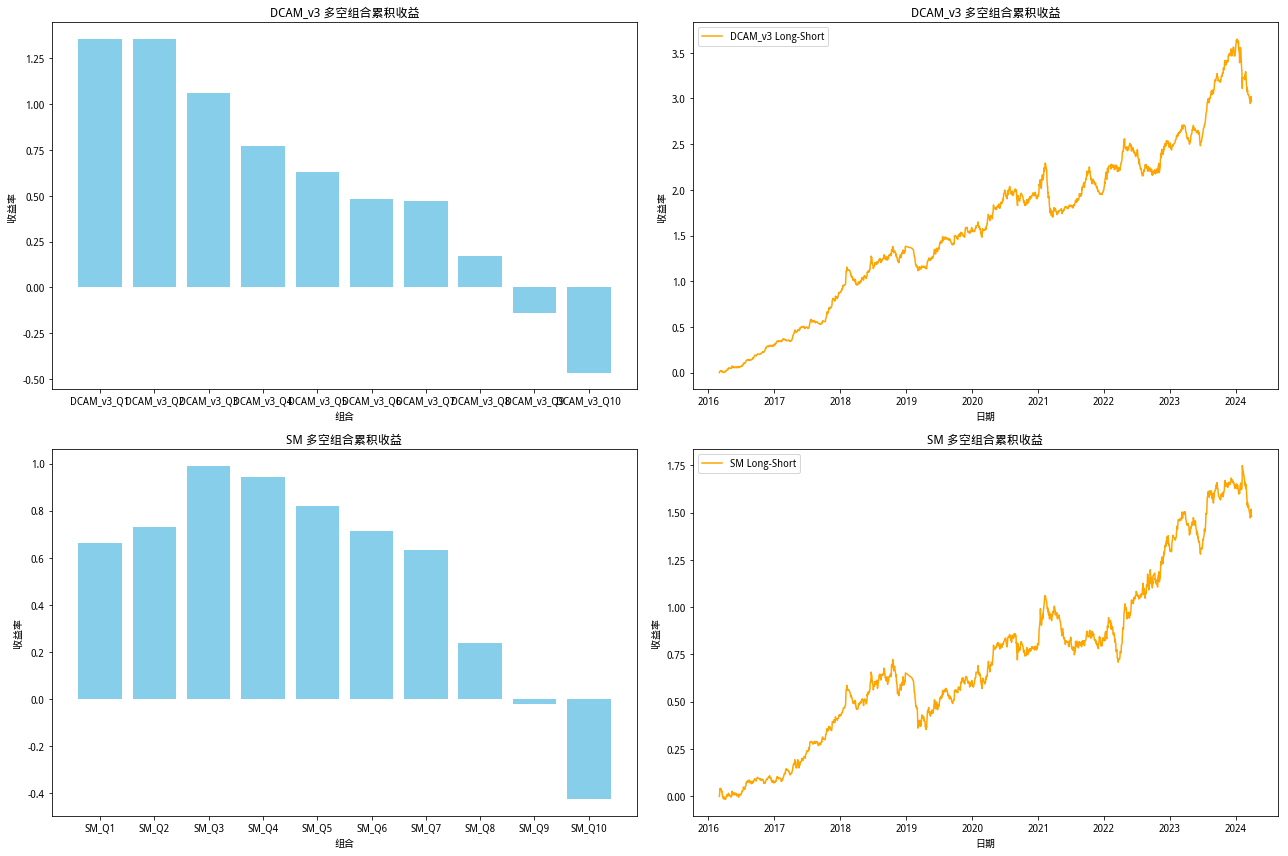

In [23]:
######################################### 执行脚本 ###################################################
root = "result/DCAM_v3/"
filename = "long_short_v3.pkl"
if not os.path.exists(root+filename):
    portfolio_ret = store_output(long_short, (data_dict_v3, ['DCAM_v3', 'SM']), filename, root)
else:
    with open(root+filename, "rb") as f:
        portfolio_ret = pickle.load(f)

plot_long_short_v2(portfolio_ret, ["DCAM_v3", "SM"])

In [24]:
######################################### 执行脚本 ###################################################
df = portfolio_ret[["DCAM_v3_long_short", "SM_long_short"]]
portfolio_summary(df)

,Annualized Return,Monthly Win Rate,Sharpe Ratio,Max Drawdown
Portfolio,,,,
DCAM_v3_long_short,0.195700,0.701031,1.482011,-0.179685
SM_long_short,0.124894,0.659794,0.844812,-0.215346


## Fama MacBeth检验

In [25]:
def process_date(date_df_tuple):  #@save
    """
    Fama MacBeth主函数
    
    params:
    - tuple: (date, df)
    
    若数据源为字典, 可用 dict.items() 转换为以上格式
    """
    day, df = date_df_tuple
    assert 0 in df.columns, f"return column (0) is missing for date {day}"
    
    # Step 1: DCAM-SM回归, 计算残差项
    df.loc[:, 'Res_DCAM'] = compute_residuals(df['DCAM_v3'], df['SM'])
    
    # Step 2: 截面回归
    params_gamma, tvalues_gamma = cross_sectional_regression(
        df,
        dep_var=0,
        indep_vars=['beta', 'size', 'SM', 'Res_DCAM']
    )

    gamma_results = {'gamma_' + key: value for key, value in params_gamma.items()}
    gamma_tvalues = {'gamma_t_' + key: value for key, value in tvalues_gamma.items()}
    
    # Step 3: SM-DCAM回归, 计算残差项
    df.loc[:, 'Res_SM'] = compute_residuals(df['SM'], df['DCAM_v3'])
    
    # Step 4: 截面回归
    params_delta, tvalues_delta = cross_sectional_regression(
        df,
        dep_var=0,
        indep_vars=['beta', 'size', 'Res_SM', 'DCAM_v3']
    )

    delta_results = {'delta_' + key: value for key, value in params_delta.items()}
    delta_tvalues = {'delta_t_' + key: value for key, value in tvalues_delta.items()}
    
    # 汇总
    results = {'date': day}
    results.update(gamma_results)
    results.update(gamma_tvalues)
    results.update(delta_results)
    results.update(delta_tvalues)
    
    return results

In [ ]:
######################################### 执行脚本 ###################################################
root = "result/DCAM_v3/"
if not os.path.exists(root+"fm_dict.pkl"):
    ft.log_print("Start fm_dict")
    fm_dict = {}
    for key in data_dict_v2.keys():
        tmp_df = data_dict_v2[key]
        fm_fac = get_factor_values(tmp_df.index.tolist(), ["beta", "size"], end_date=day, count=1)
        tmp_df["beta"] = fm_fac["beta"].T
        tmp_df["size"] = fm_fac["size"].T
        fm_dict[key] = tmp_df.dropna(axis=0)
    with open(root+"fm_dict.pkl", 'wb') as f:
        pickle.dump(fm_dict, f)
    ft.log_print("Finished")
else:
    with open(root+"fm_dict.pkl", "rb") as f:
        fm_dict = pickle.load(f)

if not os.path.exists(root+"fm_results_df.pkl"):
    ft.log_print("Start results_df")
    results = list(map(process_date, fm_dict.items()))
    results_df = pd.DataFrame(results)
    results_df.set_index('date', inplace=True)
    with open(root+"fm_results_df.pkl", 'wb') as f:
        pickle.dump(results_df, f)
    ft.log_print("Finished")
else:
    with open(root+"fm_results_df.pkl", "rb") as f:
        results_df = pickle.load(f)

summary_df = fm_summary(results_df)
summary_df

# 随机森林预测收益率 (DCAM_v4)

## 模型函数

In [27]:
def ret_zscore_reg_v4(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict):
    """
    对个股收益率和ZSCORE做随机森林回归
    
    params:
    - day: 日期
    - fac_ret_dict: 情景因子字典(数据源)
    - ctxt_fac: 单个情景因子
    - label: 层级
    - alpha_fac_ret_dict: alpha因子字典(数据源)
    
    return:
    - a: 截距项
    - b: 斜率
    """
    X_list = []
    y_list = []
    _cal = ft.get_calendar(end_date=day, count=252, freq="M")
    min_day = min(list(alpha_fac_ret_dict.keys()))
    assert _cal[0] >= min_day, "date time overflow"
    
    for day in _cal[:-1]:
        zscore = get_weighted_zscore(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict)
        return_df = alpha_fac_ret_dict[day][0].reindex(zscore.index)
        X_list.append(zscore.values)
        y_list.append(return_df.values)
    X = np.concatenate(X_list).ravel().reshape(-1, 1)
    y = np.concatenate(y_list).ravel().reshape(-1, 1)
    
    # Random Forest
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    return model

In [28]:
def get_comp_score_v4(day, fac_ret_dict, alpha_fac_ret_dict):
    """
    DCAM_v3模型个股综合得分
    
    params:
    - day: 日期
    - fac_ret_dict: 情景因子字典
    - alpha_fac_ret_dict: alpha因子字典
    
    return:
    - pd.Series: 个股综合得分(加权预期收益率)
    """
    ctxt_list = []
    fac_df = fac_ret_dict[day]
    factor_list = fac_df.columns[:fac_df.columns.tolist().index(0)]
    for ctxt_fac in factor_list:
        ft.log_print(f"情景: {ctxt_fac}")
        # 在单个情景下的不同情景区间
        ctxt_label_list = []
        for label in [1,2,3,4,5]:
            zscore = get_weighted_zscore(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict)
            model = ret_zscore_reg_v4(day, fac_ret_dict, ctxt_fac, label, alpha_fac_ret_dict)
            X_test = zscore.values.reshape(-1, 1)
            y = model.predict(X_test)
            pred_return = pd.Series(y, index=zscore.index)
            ctxt_label_list.append(pred_return)

        ctxt_df = pd.concat(ctxt_label_list)
        ctxt_list.append(ctxt_df)
    
    # 合并不同情景下个股的得分
    all_stocks = ctxt_list[0].index.union(ctxt_list[1].index).union(ctxt_list[2].index)
    reindexed_ctxt_list = [s.reindex(all_stocks) for s in ctxt_list]
    all_ctxt_df = pd.concat(reindexed_ctxt_list, axis=1)
    all_ctxt_df.columns = factor_list
    all_ctxt_df.dropna(inplace=True, axis=0)
    
    # 对情景间加权
    ctxt_weights = ctxt_distance_v2(day, alpha_fac_ret_dict)
    
    return np.sum(all_ctxt_df * ctxt_weights, axis=1)

In [29]:
def get_score_dict_v4(date_list):
    data_dict_v4 = {}
    for i in range(len(date_list)-1):
        day = date_list[i]
        ft.log_print(f"调仓日: {day}")
        
        # 加载因子字典
        with open(f"result/DCAM_v2/alpha_ret_dict.pkl", "rb") as f:
            alpha_fac_ret_dict = pickle.load(f)
        with open(f"result/DCAM_v2/fac_ret_dict.pkl", "rb") as f:
            fac_ret_dict = pickle.load(f)
            
        # DCAM_v4
        DCAM_v4 = get_comp_score_v4(day, fac_ret_dict, alpha_fac_ret_dict)

        # SM
        delta_idx = list(alpha_fac_ret_dict.keys()).index(date_list[0])
        keys = list(alpha_fac_ret_dict.keys())[i:i+delta_idx]
        tmp_alpha_dict = {key: alpha_fac_ret_dict[key] for key in keys if key in alpha_fac_ret_dict}
        ic_mean_std = ft.calculate_ic_ir(tmp_alpha_dict)
        alpha_df = alpha_fac_ret_dict.get(day)
        alpha_list = alpha_df.columns[:alpha_df.columns.tolist().index(0)]
        alpha_df = alpha_df[alpha_list]
        weighted_df = alpha_df.mul(ic_mean_std["IC_IR"], axis=1)
        SM = weighted_df.sum(axis=1).reindex(DCAM_v4.index)

        # 股票下期收益率
        ret_df = alpha_fac_ret_dict[day][0].reindex(DCAM_v4.index)

        comp_df = pd.concat([DCAM_v4, SM, ret_df], axis=1).dropna(axis=0)
        comp_df.columns = ["DCAM_v4", "SM", 0]

        data_dict_v4[day] = comp_df
    
    return data_dict_v4

In [30]:
######################################### 执行脚本 ###################################################
start_date = "20160131"
end_date = "20240331"
pre_start_day = ft.get_near_trade_day(start_date, -252*2)
cal = ft.get_calendar(start_date=pre_start_day, end_date=end_date, freq="M")
date_list = ft.get_calendar(start_date=start_date, end_date=end_date, freq="M")
factor_list = ["size", "book_to_price_ratio", "net_asset_growth_rate"]
file_path = "result/DCAM_v2/"
file_name = "fac_ret_dict.pkl"

if not os.path.exists(file_path+file_name):
    fac_ret_dict = ft.store_output(ft.get_fac_ret_dict, (cal, factor_list, "000985.XSHG", 5, True), file_name, file_path)
else:
    with open(os.path.join(file_path, file_name), "rb") as f:
        fac_ret_dict = pickle.load(f)

alpha_list = ["share_turnover_monthly", "ROC120", "earnings_to_price_ratio", "ROAEBITTTM", 
              "cash_flow_to_price_ratio", "operating_revenue_growth_rate", "net_profit_growth_rate"]
file_path = "result/DCAM_v2/"
file_name = "alpha_ret_dict.pkl"
if not os.path.exists(file_path+file_name):
    alpha_fac_ret_dict = ft.store_output(ft.get_fac_ret_dict, (cal, alpha_list, "000985.XSHG", 5, True), file_name, file_path)
else:
    with open(os.path.join(file_path, file_name), "rb") as f:
        alpha_fac_ret_dict = pickle.load(f)

root = "result/DCAM_v4/"
filename = "data_dict_v4.pkl"
if not os.path.exists(root+filename):
    data_dict_v4 = ft.store_output(get_score_dict_v4, date_list, filename, root)
else:
    with open(root+filename, "rb") as f:
        data_dict_v4 = pickle.load(f)
        
IC_mean_std = ft.calculate_ic_ir(data_dict_v4)
IC_mean_std

[2024-10-07 04:50:44] 调仓日: 2016-02-29 00:00:00
[2024-10-07 04:50:45] 情景: size
[2024-10-07 04:51:08] 情景: book_to_price_ratio
[2024-10-07 04:51:31] 情景: net_asset_growth_rate
[2024-10-07 04:51:58] 调仓日: 2016-03-31 00:00:00
[2024-10-07 04:51:59] 情景: size
[2024-10-07 04:52:22] 情景: book_to_price_ratio
[2024-10-07 04:52:46] 情景: net_asset_growth_rate
[2024-10-07 04:53:15] 调仓日: 2016-04-29 00:00:00
[2024-10-07 04:53:15] 情景: size
[2024-10-07 04:53:40] 情景: book_to_price_ratio
[2024-10-07 04:54:04] 情景: net_asset_growth_rate
[2024-10-07 04:54:33] 调仓日: 2016-05-31 00:00:00
[2024-10-07 04:54:33] 情景: size
[2024-10-07 04:54:58] 情景: book_to_price_ratio
[2024-10-07 04:55:23] 情景: net_asset_growth_rate
[2024-10-07 04:55:52] 调仓日: 2016-06-30 00:00:00
[2024-10-07 04:55:52] 情景: size
[2024-10-07 04:56:17] 情景: book_to_price_ratio
[2024-10-07 04:56:42] 情景: net_asset_growth_rate
[2024-10-07 04:57:12] 调仓日: 2016-07-29 00:00:00
[2024-10-07 04:57:13] 情景: size
[2024-10-07 04:57:38] 情景: book_to_price_ratio
[2024-10-07 04:5

[2024-10-07 06:02:13] 情景: net_asset_growth_rate
[2024-10-07 06:02:51] 调仓日: 2020-02-28 00:00:00
[2024-10-07 06:02:51] 情景: size
[2024-10-07 06:03:24] 情景: book_to_price_ratio
[2024-10-07 06:03:56] 情景: net_asset_growth_rate
[2024-10-07 06:04:33] 调仓日: 2020-03-31 00:00:00
[2024-10-07 06:04:33] 情景: size
[2024-10-07 06:05:05] 情景: book_to_price_ratio
[2024-10-07 06:05:36] 情景: net_asset_growth_rate
[2024-10-07 06:06:13] 调仓日: 2020-04-30 00:00:00
[2024-10-07 06:06:14] 情景: size
[2024-10-07 06:06:45] 情景: book_to_price_ratio
[2024-10-07 06:07:16] 情景: net_asset_growth_rate
[2024-10-07 06:07:54] 调仓日: 2020-05-29 00:00:00
[2024-10-07 06:07:54] 情景: size
[2024-10-07 06:08:25] 情景: book_to_price_ratio
[2024-10-07 06:08:57] 情景: net_asset_growth_rate
[2024-10-07 06:09:35] 调仓日: 2020-06-30 00:00:00
[2024-10-07 06:09:35] 情景: size
[2024-10-07 06:10:07] 情景: book_to_price_ratio
[2024-10-07 06:10:39] 情景: net_asset_growth_rate
[2024-10-07 06:11:16] 调仓日: 2020-07-31 00:00:00
[2024-10-07 06:11:16] 情景: size
[2024-10-07 06

[2024-10-07 07:26:36] 情景: book_to_price_ratio
[2024-10-07 07:27:14] 情景: net_asset_growth_rate
[2024-10-07 07:27:56] 调仓日: 2024-02-29 00:00:00
[2024-10-07 07:27:57] 情景: size
[2024-10-07 07:28:35] 情景: book_to_price_ratio
[2024-10-07 07:29:13] 情景: net_asset_growth_rate
[2024-10-07 07:29:56] Output stored in result/DCAM_v4/data_dict_v4.pkl


,IC_mean,IC_std,IC_IR
DCAM_v4,0.011435,0.028807,0.396964
SM,0.064677,0.109300,0.591740


## 多空组合测试

[2024-10-07 12:26:49] Output stored in result/DCAM_v4/long_short_v4.pkl


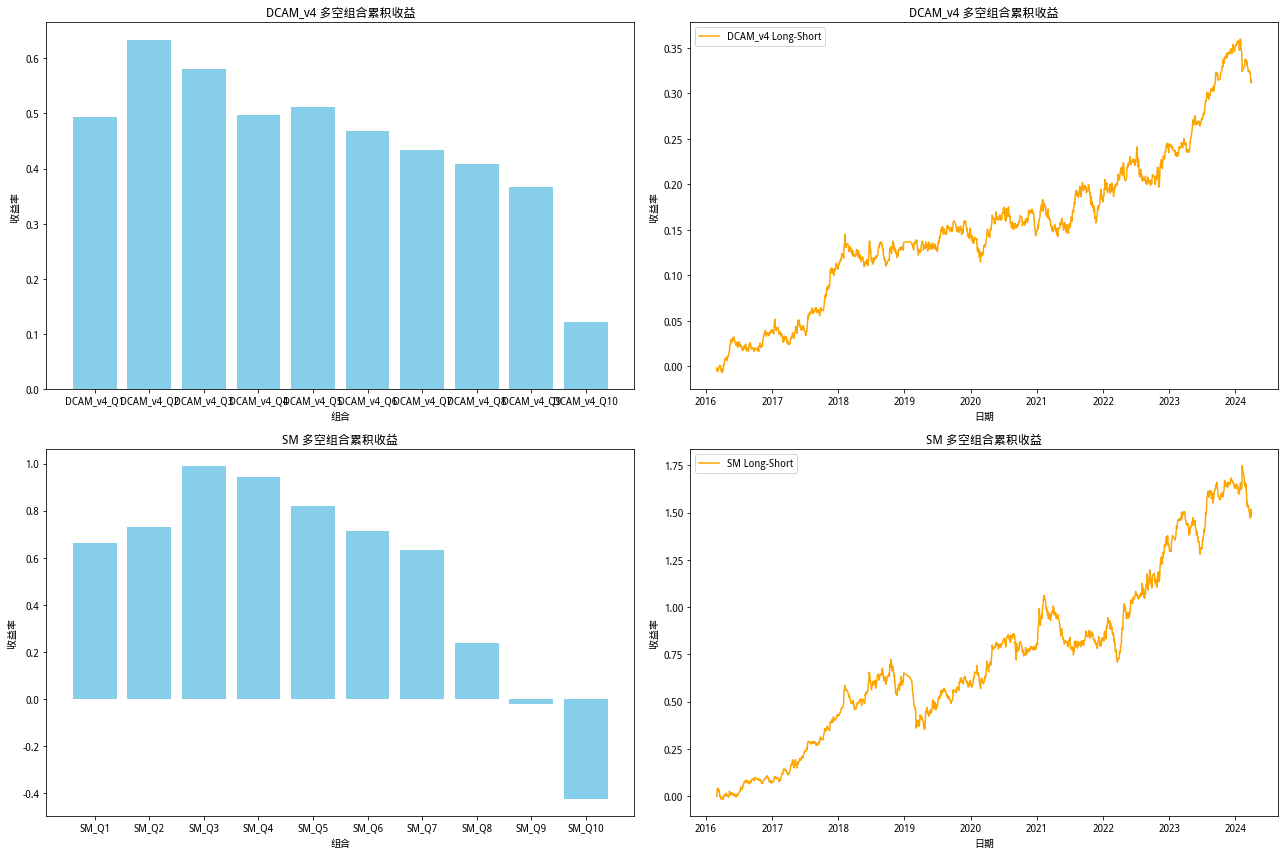

In [31]:
######################################### 执行脚本 ###################################################
root = "result/DCAM_v4/"
filename = "long_short_v4.pkl"
if not os.path.exists(root+filename):
    portfolio_ret = store_output(long_short, (data_dict_v4, ['DCAM_v4', 'SM']), filename, root)
else:
    with open(root+filename, "rb") as f:
        portfolio_ret = pickle.load(f)

plot_long_short_v2(portfolio_ret, ["DCAM_v4", "SM"])

In [32]:
######################################### 执行脚本 ###################################################
df = portfolio_ret[["DCAM_v4_long_short", "SM_long_short"]]
portfolio_summary(df)

,Annualized Return,Monthly Win Rate,Sharpe Ratio,Max Drawdown
Portfolio,,,,
DCAM_v4_long_short,0.035778,0.587629,0.159432,-0.039099
SM_long_short,0.124894,0.659794,0.844812,-0.215346


典型的机器学习算法(SVM, 随机森林)跑不过线性回归